# Histopathologic Cancer Detection 

Lets just start with some imports straight away

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta

logger = logging.getLogger()

## Purpose and goal definition

Our purpose is to be able to identify metastatic cancer in small image patches taken from larger digital pathology scans, specifically of lymph node sections. Both of us were highly interested in medical, preferebly brain problem, but after not finding a good enough dataset on kaggle for brain pathologies we decided to go with the Histopathologic Cancer Detection dataset which spiked our interest. 

We believe solving these groups of problems is highly important. Being able to detect cancer using an algorithem can potentially shorten detection and diagnosis times, reduce human error and subsequentially save patient lives and reduce further complications.

### So why is solving the Histopathologic Cancer Detection dataset challenge so important?
The **lymph system** is a part of our immune system. It includes a network of lymph vessels and nodes. Lymph vessels are a lot like the veins that collect and carry blood through the body. But instead of carrying blood, these vessels carry the clear watery fluid called lymph. Lymph fluid also contains white blood cells, which help fight infections.

Cancer can appear in the lymph nodes in 2 ways: 
* start there (lymphoma)
* spread there from somewhere else.

In the case of this project it doesn't matter to us if it started there or spread there, the question is, is it there or not. 

Generally speaking, cancer in lymph nodes is hard to find. Normal lymph nodes are tiny and can be hard to find as is, but when there’s any kind of infection, inflammation, or cancer, the nodes can get larger. Those near the body’s surface often get big enough to feel with your fingers, and some can even be seen. But if there are only a few cancer cells in a lymph node, it may look and feel normal. Lymph nodes deep in the body cannot be felt or seen. **Essentially the only way to know whether there is cancer in a lymph node is to do a biopsy**. 

**Histopathology** is the diagnosis and study of diseases of the tissues in order to study the manifestation of different deseases, including cancer. It involves examining tissues and cells under a microscope, **a biopsy**. Histopathologists are doctors who are responsible for that study and the diagnoses that follows, they help clinicians manage a patient's care.

As we can assume, manual detection of a cancer cell is a tiresome task and involves human error. Most parts of the cell are frequently part of irregular random and arbitrary visual angles. As we already mentioned, the only way to detect cancer in a lymph node is using a biopsy. Machine learning algorithems can be applied to obtain better results as compared with manual pathological detection systems, this means that solving this challenge can be cruicial for lymph node cancer patients.  

**The goal** is to identify whether a tumor is benign or of a malignant in nature, malignant tumors are cancerous, which means they should be treated as soon as possible to reduce and prevent further complications. In other words we are dealing with a **binary classification problem**.

### About histological images
In order to obtain digitalized histological images from a histological sample while preserving it's internal architecture so that the image is similar to the aspects inside a living organisem, specific sequential steps are followed. These are typically carried out manually by laboratory technicians (Bancroft and Gamble, 2008; Salve et al., 2020).

1. collection and fixation
1. dehydration and clearing
1. paraffin embedding
1. microtomy
1. staining
1. mounting
1. digitalization



### Solution evaluation

As defined by the Kaggle competition, out evaluation metric will be the area under the ROC curve between the predicted probability and the observed target, AUC. 
* **ROC** curve is a plot of True positive rate against False positive rate at various thresholds
* **AUC** is the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one

This is highly important because we are dealing with cancer tissue where a false negative can have disastrous implications. We'll be "more okay" with classifiying false positives than false negatives. In this project we'll strive to get an AUC as close to 1 as possible.

## Data collection

Data was collected directly from [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). It's a slightly modified version of the PCam dataset that can be found right [here](https://github.com/basveeling/pcam). The difference between the Kaggle version and the PCam version is that the PCam version contains duplications due to it's probabalistic sampling. 

Defining the directories where our data sits, these are constants anyway so we're going to use these variables inn the future segments of our code.

In [2]:
X_data_directory = "../../data/histopathologic-cancer-detection/train/"
y_data_directory = "../../data/histopathologic-cancer-detection/train_labels.csv"

data_to_predict_directory = "../../data/histopathologic-cancer-detection/test"

Let's just check that everything is defined as needed

In [3]:
y_data_directory

'../../data/histopathologic-cancer-detection/train_labels.csv'

Lets load the labels from the CSV file

In [4]:
y_df = pd.read_csv(y_data_directory).sample(15000, random_state=42)

Looking at the dataframe we can indeed see it consists of the id, which is also present in the file name of the image and the label itself, 0 for non cancerous and 1 for cancerous.

We can indeed see that the number of labels matches the number of images loaded from the directory.

In [5]:
y_df.count

<bound method DataFrame.count of                                               id  label
107796  d293308913e4a40cebb809d986aa9add65a76bfa      0
11942   fcd55f03496afb4b11598d9c2231e86da318e723      1
163858  5c983c8f14afeffdb098b9f3cbb68488a802b957      0
184810  71bf03e8530348e57ec07d8ce2052f215390c997      0
150958  1533406000e26663c5fadac3bcc3e38285a45bb3      1
...                                          ...    ...
71205   fa042411e7c0a686c324ea2502c7d63786396f35      0
129339  02c3f3d212cc66e30ec6c6108143d3b019dc9f5b      1
96165   093d02378f9fa7f15332e1c209de275c3c3292c5      1
158088  2bb702dc4ca8987903c32222db7a6b81f05d11c8      0
163276  bc3de4428b381fb42313fccda032640c9cb1efd4      1

[20000 rows x 2 columns]>

### Preprocess labels so we'd be able to use them for loading and visualizing images 

In [5]:
y_trs_df = y_df.copy()

In [6]:
y_trs_df['is_cancer'] = y_trs_df['label'].astype(bool)

We can see that we now have a 'is_cancer' column, which is that trannslated label from 0 and 1 to boolean value, this will make it easier to work with and also easier to understand.

In [9]:
y_trs_df.head()

id  label  is_cancer
0  f38a6374c348f90b587e046aac6079959adf3835      0      False
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1       True
2  755db6279dae599ebb4d39a9123cce439965282d      0      False
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0      False
4  068aba587a4950175d04c680d38943fd488d6a9d      0      False

We're going to concat the file name and the directory, to have for every image it's path for future user. We're then loading the images into the same dataframe, this is all done for exploration purposes.

In [7]:
y_trs_df['file_name'] = X_data_directory + y_trs_df['id'] + ".tif"

The following dataframe is going to containt the entire dataset

In [8]:
data_pd = pd.DataFrame(y_trs_df[['id','file_name','is_cancer']])

Read all the images into the following dataframe using the cv2 imread method

In [9]:
def cv_image(file_name):
    return cv.cvtColor(cv.imread(file_name), cv.COLOR_BGR2RGB)

In [10]:
data_pd['image'] = y_trs_df['file_name'].apply(cv_image)

Lets take a look at how our data looks like

In [279]:
data_pd.head()

id  \
0  f38a6374c348f90b587e046aac6079959adf3835   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77   
2  755db6279dae599ebb4d39a9123cce439965282d   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08   
4  068aba587a4950175d04c680d38943fd488d6a9d   

                                           file_name  is_cancer  \
0  ../../data/histopathologic-cancer-detection/tr...      False   
1  ../../data/histopathologic-cancer-detection/tr...       True   
2  ../../data/histopathologic-cancer-detection/tr...      False   
3  ../../data/histopathologic-cancer-detection/tr...      False   
4  ../../data/histopathologic-cancer-detection/tr...      False   

                                               image  
0  [[[244, 246, 246], [245, 247, 247], [246, 248,...  
1  [[[246, 247, 251], [245, 248, 253], [235, 238,...  
2  [[[255, 236, 255], [129, 88, 126], [126, 85, 1...  
3  [[[169, 75, 134], [188, 102, 164], [205, 128, ...  
4  [[[47, 23, 93], [120, 88, 147], [62, 19, 64], ...

Copy to a new dataframe

In [11]:
full_data_pd = data_pd.copy()

For exploration purposes we want to create a single dataframe with the image data and the label together.

## Data visualization

As written in the description of the github repository a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image. This essentially means that we can maybe crop the images and see how this influences accuracy. For now we'll keep the image as is.

In the original dataset the labels were balances between True and False and also contained information regarding the cancer in general (ie Is it cancerour? Is only the center canceros?). Kaggle removed that extra bit of information and in addition removed duplicates from the dataset.


In [22]:
full_data_pd.count()

id           20000
file_name    20000
is_cancer    20000
image        20000
dtype: int64

In [287]:
full_data_pd[['id']].drop_duplicates()

id
0       f38a6374c348f90b587e046aac6079959adf3835
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77
2       755db6279dae599ebb4d39a9123cce439965282d
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08
4       068aba587a4950175d04c680d38943fd488d6a9d
...                                          ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6
220021  d4b854fe38b07fe2831ad73892b3cec877689576
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75
220023  f129691c13433f66e1e0671ff1fe80944816f5a2
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb

[220025 rows x 1 columns]

There are no duplicates based purely on image id, but this nothing about other means of image duplications

The number of negative and positive cancer tissues.

In [289]:
full_data_pd.is_cancer.value_counts()

False    130908
True      89117
Name: is_cancer, dtype: int64

### Visualizing class labels distribution

Let's visualize our data and see the ratio between positive and negative cancer tissues.

<AxesSubplot:title={'center':'Category Images'}, ylabel='Cancer?'>

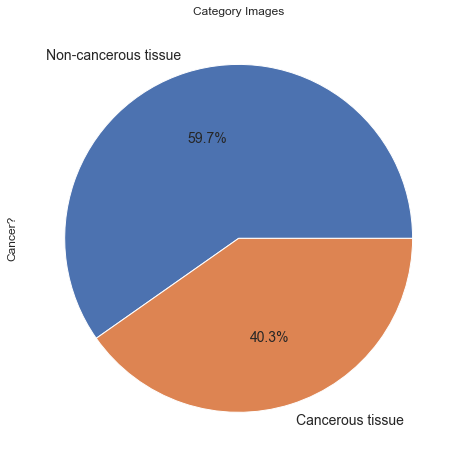

In [12]:
sns.set(style='whitegrid')

pie_chart = pd.DataFrame(full_data_pd['is_cancer'].replace(False,'Non-cancerous tissue').replace(True,'Cancerous tissue').value_counts())

pie_chart.reset_index(inplace=True)

pie_chart.plot(kind = 'pie', 
               title = 'Category Images',
               y = 'is_cancer', 
               autopct = '%1.1f%%', 
               shadow = False, 
               labels = pie_chart['index'], 
               legend = False, 
               ylabel = 'Cancer?',
               fontsize = 14, 
               figsize = (18,8))


As we see our data is unbalanced. Unbalanced data set can lead to the problem is that models trained on unbalanced datasets often have poor results when they have to generalize (predict a class or classify unseen observations). So to avoid this problem we are going to undersample the data to the lowest number which corresponds to 89117 avoiding sidetracked predictions in our future model (As a side effect this is going to make running our model on our laptops easier since originally it took us a lot of time).

Again lets take a look at the given shape of a single random negative image

In [13]:
single_negative_image = full_data_pd[full_data_pd.is_cancer == False]['image'].sample().iloc[0]

In [14]:
single_negative_image.shape

(96, 96, 3)

From the shape we can see that our images are 96x96 with three color channels.

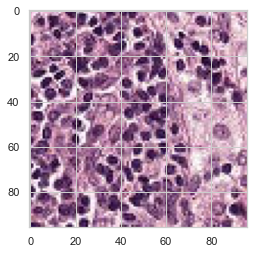

In [15]:
plt.imshow(single_negative_image)
plt.show()

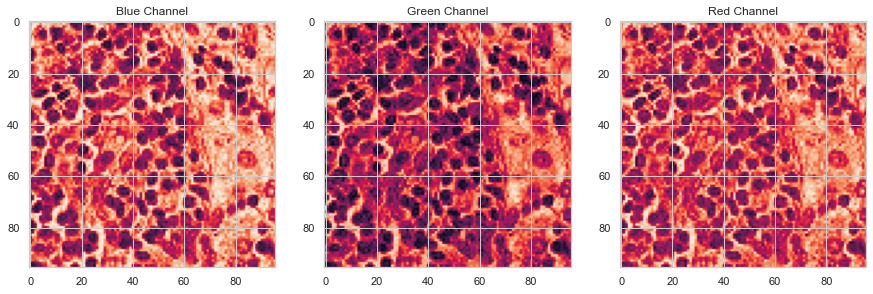

In [16]:
#Splitting into channels
blue, green, red = cv.split(single_negative_image)

# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)

plt.title("Blue Channel")
plt.imshow(blue)

fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)

fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)

plt.show()

The differences between the color channels are visible to the naked eye. The green channel is clearly darker than the red and blue channels. The red channel is darker than the blue channnel. This means that the intensity of pixel values for the green channel is lower, closer to 0, then the red and that in turn is darker than the blue channel. 

In [17]:
random_positive_image = full_data_pd[full_data_pd.is_cancer == True]['image'].sample().iloc[0]

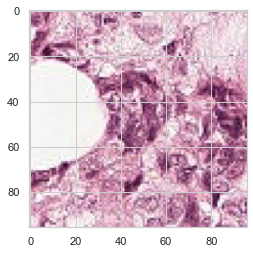

In [18]:
plt.imshow(random_positive_image)
plt.show()

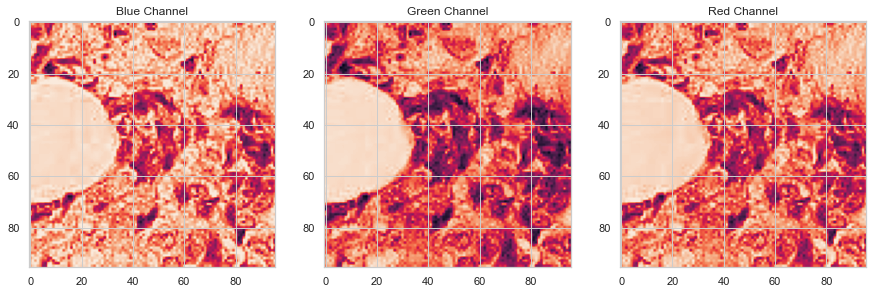

In [19]:
#Splitting into channels
blue, green, red = cv.split(random_positive_image)

# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)

plt.title("Blue Channel")
plt.imshow(blue)

fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)

fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)

plt.show()

So we can see a similar pattern for positive images. Intersting to mention, although the hierarchy of color intensity is similar, the green channel for the random positive image is brighter than for the random negative image. Later on we'll look at overall pixel value distribution and try to see if we can spot that as a pattern.

Lets visualy some images and their labels. Since a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue we'll circle the 32x32 center with a patch. A blue color for negative and a red color for positive.

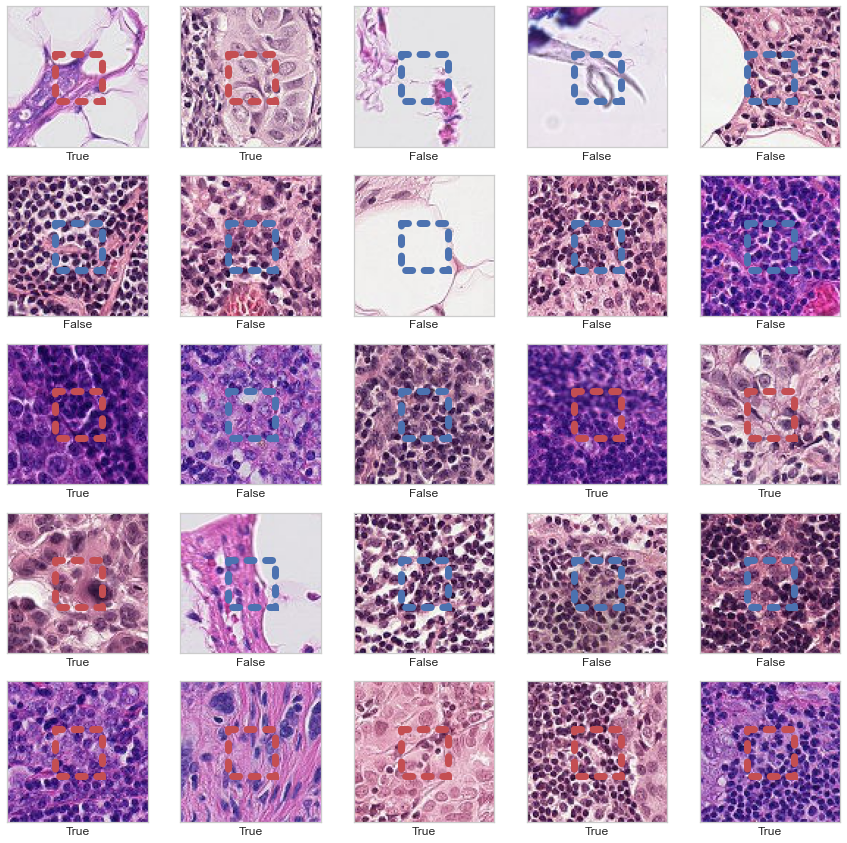

In [50]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))

shuffled_data = shuffle(full_data_pd)

for (i,current_subplot) in zip(range(25),ax.flat):
    current_row = shuffled_data.iloc[i]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    try:
        # read image and add to plot
        current_subplot.imshow(current_row['image'])
        
        current_label = current_row['is_cancer']
        
        if (current_label == True):
            current_patch_color = 'r'
        else:
            current_patch_color = 'b'
        
        # create patch recatangle around the suspected area
        box = patches.Rectangle((32,32),32,32, linewidth=7, edgecolor=current_patch_color, facecolor='none', linestyle=':', capstyle='round')
        
        # add labels and patch 
        current_subplot.xaxis.label.set_text(current_row['is_cancer'])
        current_subplot.add_patch(box)
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()


Using the naked eye, being untrained professionals, we can't make a difference between the cancerous and none cancerous images. Lets explore some more charasteristics of these images to try and spot differences that we can take into consideration when building our model.

In [14]:
stacked_images = np.stack(images_df['image']/255, axis=0)
stacked_positive_images = np.stack(images_df[images_df.is_cancer == True]['image']/255, axis=0)
stacked_negative_images = np.stack(images_df[images_df.is_cancer == False]['image']/255, axis=0)

### Noise analysis

In [37]:
from skimage.restoration import estimate_sigma

Lets take a look at the estimated guassian noise standard deviation. At first lets just take a look at a single image and get the sigma for every channel separatly. 

In [59]:
estimate_sigma(single_negative_image,channel_axis=2)

[27.10049536799072, 27.412574997612968, 27.38774611841641]

In [58]:
estimate_sigma(random_positive_image,channel_axis=2)

[19.47767978679785, 19.268003285447172, 19.702922332889194]

The output clearly shows that the non cancerous image are more noisy accross all channels, around 27, compared to cancerous image accross all channels, 19. 

In [68]:
noise_all = [estimate_sigma(image, channel_axis=2) for image in stacked_images]
noise_positive = [estimate_sigma(image, channel_axis=2) for image in stacked_positive_images]
noise_negative = [estimate_sigma(image, channel_axis=2) for image in stacked_negative_images]

In [117]:
noise_all_pd = pd.DataFrame(data=noise_all, columns=['Red channel','Green channel','Blue channel'])
noise_positive_pd = pd.DataFrame(data=noise_positive, columns=['Red channel','Green channel','Blue channel'])
noise_negative_pd = pd.DataFrame(data=noise_negative, columns=['Red channel','Green channel','Blue channel'])

<AxesSubplot:ylabel='Count'>

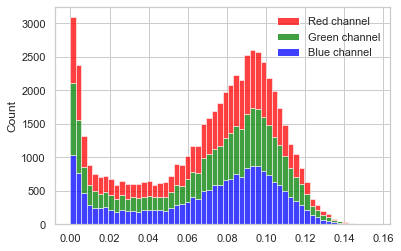

In [118]:
sns.histplot(data=noise_all_pd,stat='count', multiple='stack', palette=['red', 'green', 'blue'])

<AxesSubplot:ylabel='Count'>

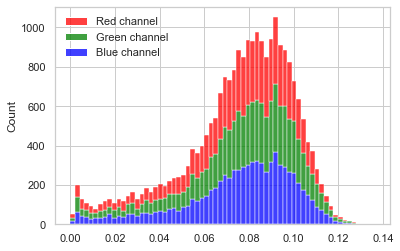

In [134]:
sns.histplot(data=noise_positive_pd, multiple='stack', palette=['red', 'green', 'blue'])

<AxesSubplot:ylabel='Count'>

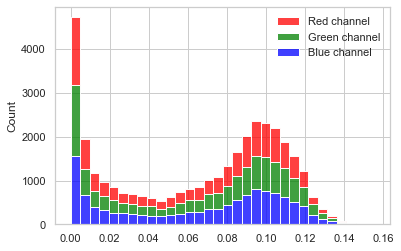

In [133]:
sns.histplot(data=noise_negative_pd, multiple='stack', palette=['red', 'green', 'blue'])

In [81]:
from skimage.restoration import denoise_tv_chambolle

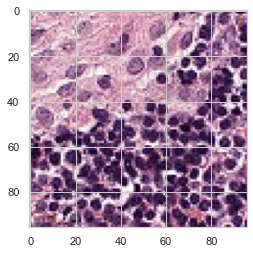

In [82]:
plt.imshow(single_negative_image)

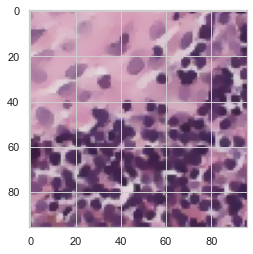

In [84]:
plt.imshow(denoise_tv_chambolle(single_negative_image, channel_axis=2))

In [86]:
estimate_sigma(denoise_tv_chambolle(single_negative_image, channel_axis=2), channel_axis=2)

[0.022688084521770208, 0.02329241261910211, 0.019373986935961374]

### Principal component analysis

PCA identifies the attributes that account for the most variance in the data. Let's keep in mind we have 96x96x3 = 27648 features per image, so it'll be interesting to visualise and also important to identify the number of components we can go down into when performinng dimentionality reduction using image compression by PCA.

In [12]:
from sklearn.decomposition import PCA

In [13]:
images_df = full_data_pd[['image','is_cancer']].copy()

We are now going to normalise and reshape the data in order to be able to use it for PCA.

In [15]:
image_sample_stacked = stacked_images.flatten(). \
                       reshape(stacked_images.shape[0],
                              stacked_images.shape[1]*stacked_images.shape[2]*stacked_images.shape[3])
positive_image_sample_stacked = stacked_positive_images.flatten(). \
                       reshape(stacked_positive_images.shape[0],
                              stacked_positive_images.shape[1]*stacked_positive_images.shape[2]*stacked_positive_images.shape[3])
negative_image_sample_stacked = stacked_negative_images.flatten(). \
                       reshape(stacked_negative_images.shape[0],
                              stacked_negative_images.shape[1]*stacked_negative_images.shape[2]*stacked_negative_images.shape[3])

In [16]:
image_sample_stacked.shape

(20000, 27648)

As we can see in the shape, each image with all three channels is now represented in a single array. We've tried to find the number of components that would explain 90% of the varience in the data.

In [17]:
pca = PCA(n_components=3000) 
pca_negative = PCA(n_components=50) 
pca_positive = PCA(n_components=50) 

images_pixels_pca = pca.fit_transform(image_sample_stacked)
positive_images_pixels_pca = pca_positive.fit_transform(positive_image_sample_stacked)
negative_images_pixels_pca = pca_negative.fit_transform(negative_image_sample_stacked)

In [26]:
n_components = len(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1
df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T
mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance# (iii.) Print explained variance as plain text
print('PCA Overview')
print('='*40)
print("Total: {} components".format(n_components))
print('-'*40)
print('Mean explained variance:', mean_explained_variance)
print('-'*40)
print(df_explained_variance.head(10))
print('-'*40)
print(df_explained_variance.tail(10))
print('-'*40)

PCA Overview
Total: 3000 components
----------------------------------------
Mean explained variance: 0.0003040942608585907
----------------------------------------
    explained variance  cumulative
1             0.384448    0.384448
2             0.018060    0.402508
3             0.015397    0.417906
4             0.015136    0.433041
5             0.006181    0.439222
6             0.005992    0.445214
7             0.005473    0.450687
8             0.004944    0.455631
9             0.003601    0.459232
10            0.003583    0.462815
----------------------------------------
      explained variance  cumulative
2991            0.000030    0.912017
2992            0.000030    0.912047
2993            0.000030    0.912076
2994            0.000030    0.912106
2995            0.000030    0.912135
2996            0.000030    0.912165
2997            0.000030    0.912194
2998            0.000030    0.912224
2999            0.000029    0.912253
3000            0.000029    0.912283
--

The first component makes up for around 38.44% of the explained variance. This is relatively low as compared to other datasets. It  indicates that a major share, around 62%, of observations distributes across more than one dimension. If we want to use PCA to reduce the data’s dimensionality and retain at least 90% variance of the original data we would have to use a significantly higher number of components. 

In [67]:
df_explained_variance[df_explained_variance.cumulative > 0.9].head(1)

explained variance  cumulative
2638            0.000038    0.900017

So as we can see in order to be able to retain 90% of the variance in the images we will have to use 2348 principal components. This will still be a significant reduction compared to the original 27648.

Let's visualise the discussion using a bar plot for top 10 principal components

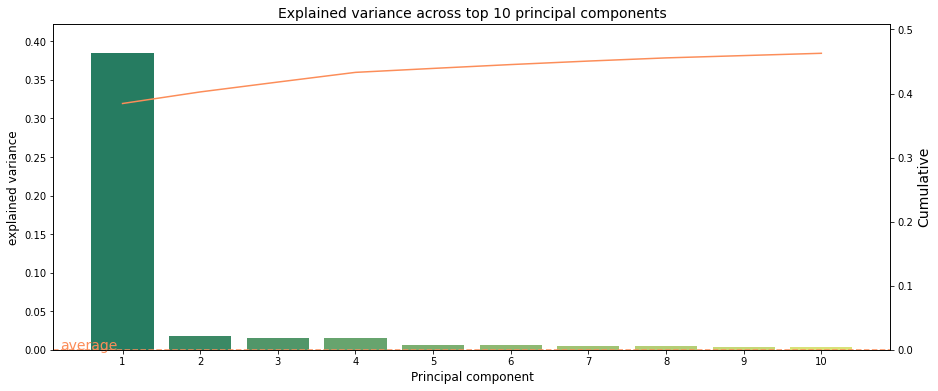

In [19]:
limit_df = 10

df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]

fig, ax1 = plt.subplots(figsize=(15,6))

ax1.set_title('Explained variance across top 10 principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)

ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')

ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14)

max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])

ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))

plt.show()

As we've already discussed and as visible from the bar plot again, the first component captures disproportionately more variance than others. It could be a sign that variables inform about the same underlying factor or do not add additional dimensions, but say the same thing from a marginally different angle.

Let's explore the output of the PCA for positive versus negative images and see if we can find a difference there.

Positive images PCA Overview
Total: 50 components
----------------------------------------
Mean explained variance: 0.008421840513089073
----------------------------------------
    explained variance  cumulative
1             0.259918    0.259918
2             0.025861    0.285779
3             0.016623    0.302402
4             0.015067    0.317469
5             0.006638    0.324107
6             0.006064    0.330172
7             0.005569    0.335741
8             0.005269    0.341010
9             0.004211    0.345221
10            0.004086    0.349306
----------------------------------------
    explained variance  cumulative
41            0.001338    0.409988
42            0.001323    0.411311
43            0.001299    0.412610
44            0.001273    0.413883
45            0.001260    0.415143
46            0.001221    0.416364
47            0.001206    0.417570
48            0.001187    0.418758
49            0.001171    0.419928
50            0.001164    0.421092
-----------

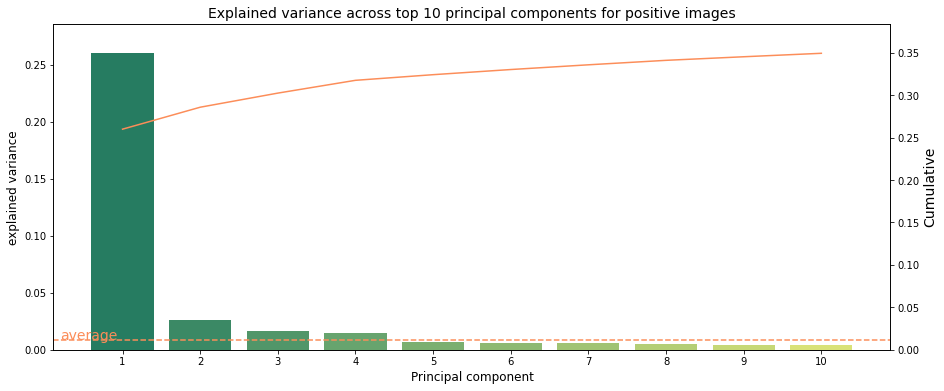

In [21]:
positive_n_components = len(pca_positive.explained_variance_ratio_)
positive_explained_variance = pca_positive.explained_variance_ratio_
positive_cum_explained_variance = np.cumsum(positive_explained_variance)
idx_positive = np.arange(positive_n_components)+1
df_positive_explained_variance = pd.DataFrame([positive_explained_variance, positive_cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx_positive).T
mean_positive_explained_variance = df_positive_explained_variance.iloc[:,0].mean() # calculate mean explained variance# (iii.) Print explained variance as plain text
print('Positive images PCA Overview')
print('='*40)
print("Total: {} components".format(positive_n_components))
print('-'*40)
print('Mean explained variance:', mean_positive_explained_variance)
print('-'*40)
print(df_positive_explained_variance.head(10))
print('-'*40)
print(df_positive_explained_variance.tail(10))
print('-'*40)

limit_df = 10

df_positive_explained_variance_limited = df_positive_explained_variance.iloc[:limit_df,:]

fig, ax1 = plt.subplots(figsize=(15,6))

ax1.set_title('Explained variance across top 10 principal components for positive images', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)

ax2 = sns.barplot(x=idx_positive[:limit_df], y='explained variance', data=df_positive_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx_positive[:limit_df]-1, y='cumulative', data=df_positive_explained_variance_limited, color='#fc8d59')

ax1.axhline(mean_positive_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_positive_explained_variance+(mean_positive_explained_variance*.05), "average", color='#fc8d59', fontsize=14)

max_y1 = max(df_positive_explained_variance_limited.iloc[:,0])
max_y2 = max(df_positive_explained_variance_limited.iloc[:,1])

ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))

plt.show()

Negative images PCA Overview
Total: 50 components
----------------------------------------
Mean explained variance: 0.011128549589927428
----------------------------------------
    explained variance  cumulative
1             0.435051    0.435051
2             0.015391    0.450442
3             0.015065    0.465507
4             0.013484    0.478991
5             0.006067    0.485058
6             0.005841    0.490899
7             0.004911    0.495810
8             0.004524    0.500334
9             0.003449    0.503784
10            0.003403    0.507187
----------------------------------------
    explained variance  cumulative
41            0.000848    0.549464
42            0.000818    0.550282
43            0.000810    0.551092
44            0.000805    0.551896
45            0.000795    0.552691
46            0.000767    0.553459
47            0.000761    0.554219
48            0.000752    0.554971
49            0.000736    0.555707
50            0.000720    0.556427
-----------

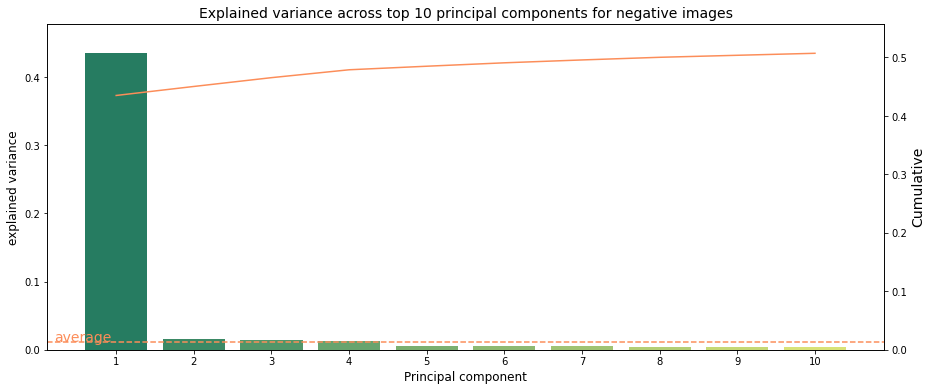

In [23]:
negative_n_components = len(pca_negative.explained_variance_ratio_)
negative_explained_variance = pca_negative.explained_variance_ratio_
negative_cum_explained_variance = np.cumsum(negative_explained_variance)
idx_negative = np.arange(negative_n_components)+1
df_negative_explained_variance = pd.DataFrame([negative_explained_variance, negative_cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx_negative).T
mean_negative_explained_variance = df_negative_explained_variance.iloc[:,0].mean() # calculate mean explained variance# (iii.) Print explained variance as plain text
print('Negative images PCA Overview')
print('='*40)
print("Total: {} components".format(negative_n_components))
print('-'*40)
print('Mean explained variance:', mean_negative_explained_variance)
print('-'*40)
print(df_negative_explained_variance.head(10))
print('-'*40)
print(df_negative_explained_variance.tail(10))
print('-'*40)

limit_df = 10

df_negative_explained_variance_limited = df_negative_explained_variance.iloc[:limit_df,:]

fig, ax1 = plt.subplots(figsize=(15,6))

ax1.set_title('Explained variance across top 10 principal components for negative images', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)

ax2 = sns.barplot(x=idx_negative[:limit_df], y='explained variance', data=df_negative_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx_negative[:limit_df]-1, y='cumulative', data=df_negative_explained_variance_limited, color='#fc8d59')

ax1.axhline(mean_negative_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_negative_explained_variance+(mean_negative_explained_variance*.05), "average", color='#fc8d59', fontsize=14)

max_y1 = max(df_negative_explained_variance_limited.iloc[:,0])
max_y2 = max(df_negative_explained_variance_limited.iloc[:,1])

ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))

plt.show()

Interestingly the 1st principal component for the negative non cancerous images has an explained variance higher, 43%, than the 1st principal component for the positive cancerous images, 26%. 

Lets plot the top two principal components in the data for all, negative and positive images

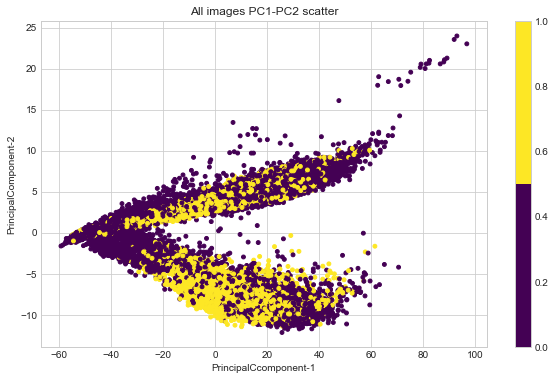

In [33]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (10,6))

# choose color map
c_map = plt.cm.get_cmap('viridis', 2)

plt.scatter(images_pixels_pca[:, 0], images_pixels_pca[:, 1], s = 15,
            cmap = c_map , c = images_df['is_cancer'])

plt.colorbar()

plt.xlabel('PrincipalCcomponent-1') , plt.ylabel('PrincipalComponent-2')

plt.title('All images PC1-PC2 scatter')

plt.show()

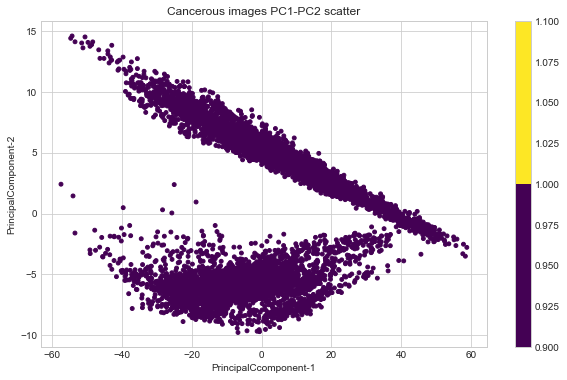

In [32]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (10,6))

# choose color map
c_map = plt.cm.get_cmap('viridis', 2)

plt.scatter(positive_images_pixels_pca[:, 0], positive_images_pixels_pca[:, 1], s = 15,
            cmap = c_map , c = images_df[images_df.is_cancer == True]['is_cancer'])

plt.colorbar()

plt.xlabel('PrincipalCcomponent-1') , plt.ylabel('PrincipalComponent-2')

plt.title('Cancerous images PC1-PC2 scatter')

plt.show()

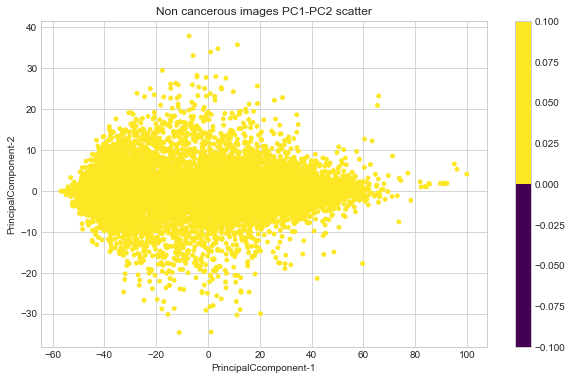

In [34]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize = (10,6))

# choose color map
c_map = plt.cm.get_cmap('viridis', 2)

plt.scatter(negative_images_pixels_pca[:, 0], negative_images_pixels_pca[:, 1], s = 15,
            cmap = c_map , c = images_df[images_df.is_cancer == False]['is_cancer'])

plt.colorbar()

plt.xlabel('PrincipalCcomponent-1') , plt.ylabel('PrincipalComponent-2')

plt.title('Non cancerous images PC1-PC2 scatter')

plt.show()

### Exploring image pixel values distribution

Reshaping our image array in such a way it'll be easier to visualize. 

In [148]:
stacked_negative_images = np.stack(full_data_pd[full_data_pd['is_cancer'] == False]['image'], axis=0)
stacked_positive_images = np.stack(full_data_pd[full_data_pd['is_cancer'] == True]['image'], axis=0)

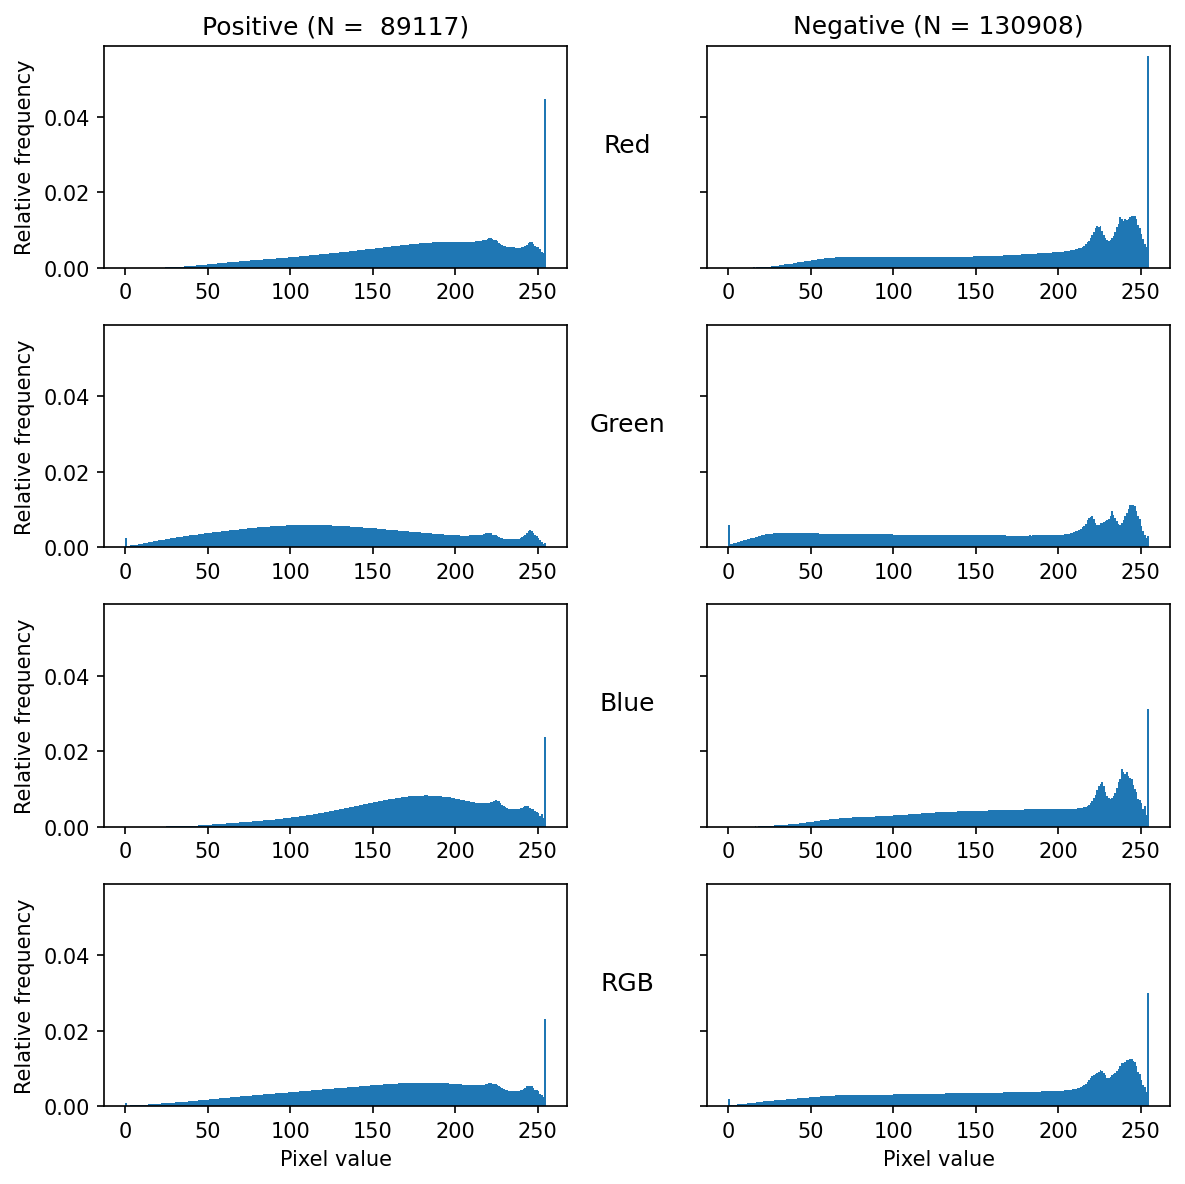

In [149]:
fig, axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels

# RED channel
axs[0,0].hist(stacked_positive_images[:,:,:,0].flatten(),bins=256,density=True)
axs[0,1].hist(stacked_negative_images[:,:,:,0].flatten(),bins=256,density=True)

# GREEN channel
axs[1,0].hist(stacked_positive_images[:,:,:,1].flatten(),bins=256,density=True)
axs[1,1].hist(stacked_negative_images[:,:,:,1].flatten(),bins=256,density=True)

# BLUE Channel
axs[2,0].hist(stacked_positive_images[:,:,:,2].flatten(),bins=256,density=True)
axs[2,1].hist(stacked_negative_images[:,:,:,2].flatten(),bins=256,density=True)

#All channels
axs[3,0].hist(stacked_positive_images.flatten(),bins=256,density=True)
axs[3,1].hist(stacked_negative_images.flatten(),bins=256,density=True)

#Set image labels
axs[0,0].set_title("Positive (N =  " + str(stacked_positive_images.shape[0]) + ")");
axs[0,1].set_title("Negative (N = " + str(stacked_negative_images.shape[0]) + ")");

axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)

for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
    
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")

fig.tight_layout()

plt.show()

Looking at these plots we can notice several interesting differences between cancerous and non cancerous samples.

* In general looks like there is a peak of very saturated images (250 pixel value frequenncy, white). We cann see the frequency peak for blue and red channels, for both cancerous and non cancerous images, and also for all colors all together (RGB).
* There are no such peak only for the green channel in both cancerous and non cancerous images.
* Non cancerous images seem to be more saturated, higher values more frequent, than cancerous images.
* Cancerous images tend to have lower frequency values for the green channel, meaning the green color in the is less saturated, compared to the reds and blues which are brighter and more dominant. This is very interesting since when a pathologist looks at a biopsy of a suspected cancer, the histological section is likely to be stained with a combination of hematoxylin and eosin, it produces blues, violets and reds (Fox, 2000; Krithiga & Geetha, 2020).
* Non cancerous images have more saturated pixel value frequency for all color channels.

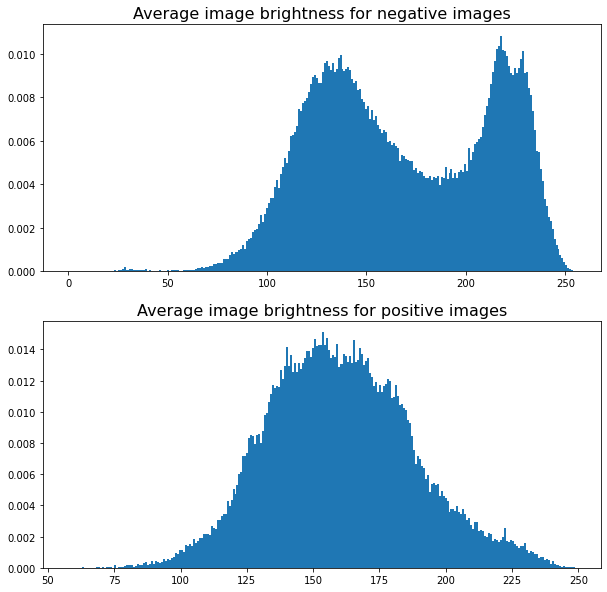

In [20]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].hist(np.mean(stacked_negative_images, axis=(1,2,3)), bins=256, density=True)
ax[1].hist(np.mean(stacked_positive_images, axis=(1,2,3)), bins=256, density=True)

ax[0].set_title("Average image brightness for negative images", fontsize=16)
ax[1].set_title("Average image brightness for positive images", fontsize=16)

plt.show()

Interestingly enough we can see that there is a difference in image brightness between cancerous and non cancerous images.
* Cancerous images have a normal like distribution of image brightness.
* Non cancerous images have a multimodal distribution of image brightness. 

### Exploring low/high contract images

In [20]:
from skimage.exposure import is_low_contrast

In [21]:
def is_low_contrast_func(image):
    return bool(is_low_contrast(image, fraction_threshold=0.1))

In [22]:
low_contrast_pd = full_data_pd.copy()
low_contrast_pd['is_low_contrast_0.1'] = low_contrast_pd['image'].apply(is_low_contrast_func)

<AxesSubplot:xlabel='is_low_contrast_0.1', ylabel='count'>

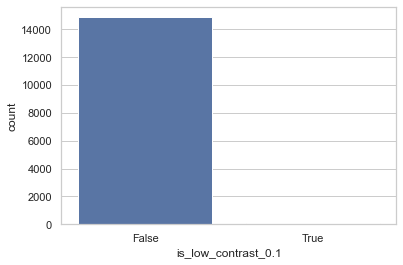

In [23]:
sns.countplot(data=low_contrast_pd, x='is_low_contrast_0.1')

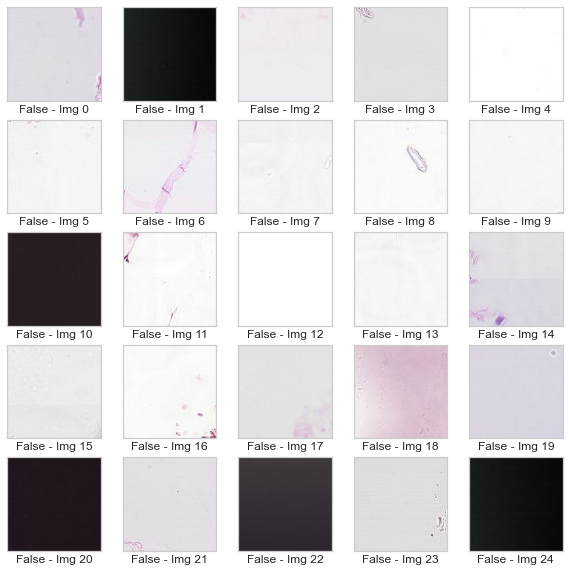

In [107]:
plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == True])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[i]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    try:
        plt.imshow(current_row['image'])

        plt.xlabel(f"{current_row['is_cancer']} - Img {i}")
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

These immages look generally like mistakes even to the naked eye. Some look like mmaybe the edge of the microscope scanning the sample being too dark or too bright. Some look completly single color. In other words these look like images that don't have an actual sample of tissue in them. 

At this point we want to drill down into the labels these low contrast images belong to, to gain some more insights.

<AxesSubplot:xlabel='is_cancer', ylabel='count'>

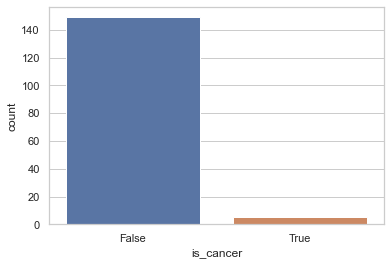

In [108]:
sns.countplot(data=low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == True], x='is_cancer')

Looks like most images belong to non cancerous tissue images. This is interesting, because from what we see when visualising a sample of images and from what we gather, thesea are indeed non cancerous images. Lets take a look at some of these images.

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


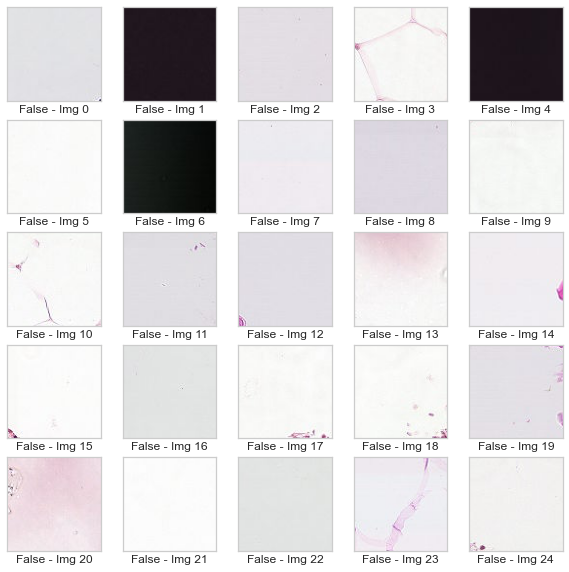

In [109]:
plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == True][low_contrast_pd['is_cancer'] == False])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[i]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    try:
        plt.imshow(current_row['image'])

        plt.xlabel(f"{current_row['is_cancer']} - Img {i}")
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

Surprisingly enough although some of these images are indeed single color

/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


IndexError: single positional indexer is out-of-bounds

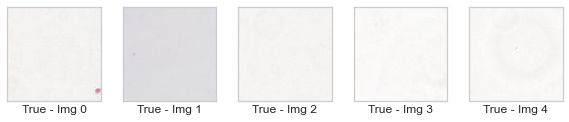

In [110]:
plt.figure(figsize=(10,10))

shuffled_low_contrast = shuffle(low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == True][low_contrast_pd['is_cancer'] == True])

for i in range(25):
    current_row = shuffled_low_contrast.iloc[i]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    try:
        plt.imshow(current_row['image'])

        plt.xlabel(f"{current_row['is_cancer']} - Img {i}")
    except Exception as e:
        logger.error("A problem happened while trying to represent the image", e)
    
plt.show()

<AxesSubplot:xlabel='is_cancer', ylabel='count'>

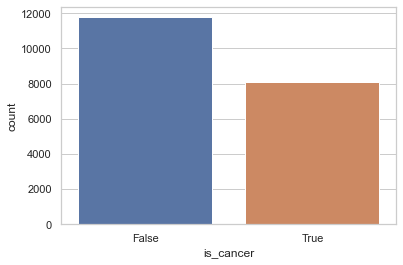

In [111]:
sns.countplot(data=low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == False], x='is_cancer')

In [24]:
cleaned_data = pd.DataFrame(data=low_contrast_pd[low_contrast_pd["is_low_contrast_0.1"] == False])

In [25]:
cleaned_data.drop(columns=["is_low_contrast_0.1"],inplace=True)

## Feature extraction

https://www.hindawi.com/journals/bmri/2022/9821773/
HOG
GLCM
LBP


https://link.springer.com/article/10.1007/s40031-022-00745-3

LDTP
GLCM

https://arxiv.org/pdf/2202.13270.pdf
1. Split into color channels
1. multi-resolution analysis of a texture employing a wavelet transform, generating four subbands: a, h, v, and d
1. Compute taxonomic measures, Shannon entropy, and total information, resulting in a 9-dimensional vector for each subband. Taxonomic measures comprise taxonomic diversity, 7taxonomic distinctness, the sum of phylogenetic distances, average distance from the nearest neighbor, extensive quadratic entropy, intensive quadratic entropy, and total taxonomic distinctness (Ataky and Lameiras Koerich, 2022)
1. Biodiversity measures from step 2′′ comprise Margalef’s and Menhinick’s diversity indexes, Berger-Parker dominance, Fisher’s alpha diversity metric, Kempton-Taylor index of alpha diversity, McIntosh’s evenness measure, and Shannon-Wiener diversity index (Ataky and Lameiras Koerich, 2022). 

### Histogram of oriented gradients (HOG)

In [26]:
from skimage.feature import hog as hog_feature
from skimage import exposure

Lets take a look at the histogram of oriented gradients for the two random cancerous and non cancerous images. 

For the HOG feature descriptor, the most common image size is 64×128 (width x height) pixels. From what we read online the original paper by Dalal and Triggs mainly focused on human recognition and detection, althout HOG is used over and over againn in the analysis and classification of histopathological images. Galal and Triggs found that 64×128 is the ideal image size, so we're going to resize our images to 64x128.

In [53]:
fd_positive, hog_positive_image = hog_feature(cv.resize(random_positive_image, (64,128)), feature_vector=True, orientations=9, 
                    pixels_per_cell=(6, 6), cells_per_block=(4, 4), 
                    block_norm='L2-Hys', visualize=True, transform_sqrt=True, channel_axis=2)
fd_negative, hog_negative_image = hog_feature(single_negative_image, feature_vector=True, orientations=9, 
                    pixels_per_cell=(6, 6), cells_per_block=(4, 4),
                    block_norm='L2-Hys', visualize=True, transform_sqrt=True, channel_axis=2)

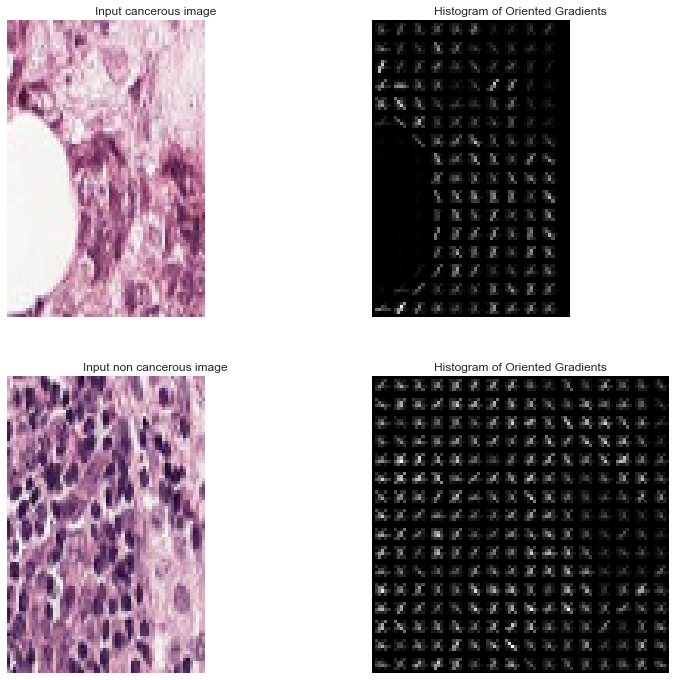

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

ax[0,0].axis('off')
ax[0,0].imshow(cv.resize(random_positive_image, (64,128)), cmap=plt.cm.gray)
ax[0,0].set_title('Input cancerous image')

ax[1,0].axis('off')
ax[1,0].imshow(cv.resize(single_negative_image, (64,128)), cmap=plt.cm.gray)
ax[1,0].set_title('Input non cancerous image')

# Rescale histogram for better display
hog_image_positive_rescaled = exposure.rescale_intensity(hog_positive_image, in_range=(0, 10))
hog_image_negative_rescaled = exposure.rescale_intensity(hog_negative_image, in_range=(0, 10))

ax[0,1].axis('off')
ax[0,1].imshow(hog_image_positive_rescaled, cmap=plt.cm.gray)
ax[0,1].set_title('Histogram of Oriented Gradients')

ax[1,1].axis('off')
ax[1,1].imshow(hog_image_negative_rescaled, cmap=plt.cm.gray)
ax[1,1].set_title('Histogram of Oriented Gradients')

plt.show()

It's interesting to look at the histogram of oriented gradients image. Looking at the bottom we have the non cancerous image, we can see a relatily clear pink surface and dark dots on the bottom half. This change of surface reflects really well in the historgram. The cancerous has leff of a change in contrast, but does have different darker circles. This is relativly noticable in the histogram, a lot of movement but it's relativly sparse in the output hog.

In [31]:
fd_positive

array([0.41103679, 0.41103679, 0.26444189, 0.04921844, 0.41103679,
       0.19451598, 0.21226244, 0.41103679, 0.41103679, 0.43052979,
       0.1941119 , 0.14342977, 0.32709518, 0.25225941, 0.2345175 ,
       0.40007032, 0.43052979, 0.43052979, 0.37337349, 0.3572231 ,
       0.37337349, 0.37337349, 0.18208448, 0.37337349, 0.05282347,
       0.37337349, 0.37337349, 0.36280325, 0.36280325, 0.12235964,
       0.36280325, 0.36280325, 0.36280325, 0.25227909, 0.36280325,
       0.36280325, 0.35487127, 0.35487127, 0.35487127, 0.30041372,
       0.16797701, 0.35487127, 0.35487127, 0.35487127, 0.35487127,
       0.38913172, 0.38913172, 0.27856377, 0.30641819, 0.22933865,
       0.38913172, 0.3072851 , 0.38913172, 0.27531035, 0.37730193,
       0.37730193, 0.34915647, 0.37730193, 0.33994583, 0.22226923,
       0.20073804, 0.37730193, 0.32155907, 0.45339867, 0.45339867,
       0.21029771, 0.15295244, 0.45339867, 0.38825735, 0.09826082,
       0.20258569, 0.33797845, 0.34845786, 0.34845786, 0.34845

In [55]:
len(fd_positive)

18144

As seen above we have received a feature vector of the oriented gradients for each image with 1890 features. Lets now extract the hog for all the images.

In [49]:
def get_hog_image(image):
    return hog_feature(cv.resize(image, (64,128)), feature_vector=True, orientations=9, 
                       pixels_per_cell=(6, 6), cells_per_block=(4, 4), block_norm='L2-Hys', 
                       visualize=False, transform_sqrt=True, channel_axis=2)

In [57]:
hog_column_names = ["{}{}".format('hog_',i) for i in range(0,len(fd_positive))]

In [51]:
hog_features = cleaned_data.apply(lambda row: get_hog_image(row['image']), result_type='expand', axis=1)

In [58]:
hog_features.columns = hog_column_names

In [ ]:
features_data = pd.concat([cleaned_data,hog_features], axis=1)

In [38]:
features_data.head(2)

id  \
11942   fcd55f03496afb4b11598d9c2231e86da318e723   
163858  5c983c8f14afeffdb098b9f3cbb68488a802b957   

                                                file_name  is_cancer  \
11942   ../../data/histopathologic-cancer-detection/tr...       True   
163858  ../../data/histopathologic-cancer-detection/tr...      False   

                                                    image     hog_0     hog_1  \
11942   [[[66, 36, 126], [74, 40, 126], [169, 131, 208...  0.347688  0.347688   
163858  [[[51, 18, 61], [92, 57, 99], [131, 95, 133], ...  0.340185  0.340185   

           hog_2     hog_3     hog_4     hog_5  ...   hog_872   hog_873  \
11942   0.341281  0.255216  0.347688  0.305072  ...  0.396560  0.356965   
163858  0.340185  0.307658  0.340185  0.340185  ...  0.353073  0.357202   

         hog_874   hog_875   hog_876   hog_877   hog_878   hog_879   hog_880  \
11942   0.356965  0.356965  0.356965  0.185154  0.288097  0.356965  0.343765   
163858  0.357202  0.177248  0.352244  0.357202  0.280976  0.357202  0.357202   

         hog_881  
11942   0.356965  
163858  0.357202  

[2 rows x 886 columns]

We can see the HOG feature vector is now part of our dataframe for every image.

In [39]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, roc_curve, auc
from sklearn.inspection import DecisionBoundaryDisplay

In [67]:
clf = svm.SVC(kernel="linear")
X_hog = hog_features.copy()
y = features_data['is_cancer']

In [60]:
X_hog_train, X_hog_test, y_hog_train, y_hog_test = train_test_split(X_hog, y, test_size=0.30, random_state=42)

In [ ]:
clf.fit(X_hog_train, y_hog_train)

In [62]:
y_hog_pred = clf.predict(X_hog_test)

In [63]:
print("Accuracy: "+str(accuracy_score(y_hog_test, y_hog_pred)))
print('\n')
print(classification_report(y_hog_test, y_hog_pred))

Accuracy: 0.5938620071684588


              precision    recall  f1-score   support

       False       0.59      1.00      0.75      2651
        True       0.00      0.00      0.00      1813

    accuracy                           0.59      4464
   macro avg       0.30      0.50      0.37      4464
weighted avg       0.35      0.59      0.44      4464



/Users/simonameriam/opt/anaconda3/envs/data_sciense_keras_project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonameriam/opt/anaconda3/envs/data_sciense_keras_project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/simonameriam/opt/anaconda3/envs/data_sciense_keras_project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [590]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_curve, auc

print("Accuracy: "+str(accuracy_score(y_hog_test, y_hog_pred)))
print('\n')
print(classification_report(y_hog_test, y_hog_pred))

Accuracy: 0.6074907625125966


              precision    recall  f1-score   support

       False       0.62      0.82      0.71      3480
        True       0.55      0.30      0.39      2474

    accuracy                           0.61      5954
   macro avg       0.59      0.56      0.55      5954
weighted avg       0.59      0.61      0.58      5954



In [46]:
train_fpr, train_tpr, tr_thresholds = roc_curve(X_hog_test, y_hog_pred)

ValueError: continuous-multioutput format is not supported

NameError: name 'train_fpr' is not defined

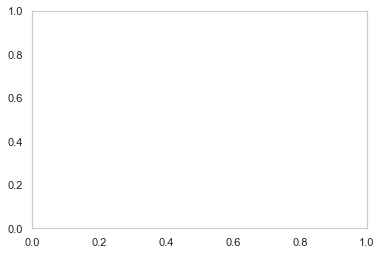

In [45]:
test_fpr, test_tpr, te_thresholds = roc_curve(y_hog_test, y_hog_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### Local binary pattern (LBP)

Alhindi et al. (2018) achieved the highest results with features extracted by LBP compared to HOG and ANN, for the task of classification of histopathology images. Wang (2009) has combined LBP with HOG descriptor to improve detection performance. The combined use of HOG and LBP for the classification of histopathology images appears in the literature a few more times, Cai et al. (2022) extracted three statistical features; HOG, LBP and Gray-Level Co-Occurrence Matrix (GLCM).

In [472]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb

radius = 3
# n_points = 8 * radius
n_points = 8
METHOD = 'uniform'
plt.rcParams['font.size'] = 9

In [473]:
random_image = cleaned_data.sample(1, random_state=42)['image'].iloc[0]

LBP works with gray scale images, so first thing is convert the original image to gray scale.

In [474]:
gray_random_image = cv.cvtColor(random_image, cv.COLOR_BGR2GRAY)

In [475]:
lbp_random_image = local_binary_pattern(gray_random_image, n_points, radius, 'default')       

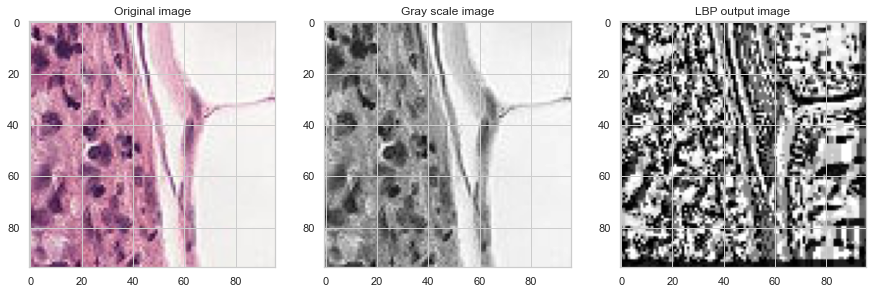

In [476]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].set_title('Original image')
ax[0].imshow(random_image)

ax[1].set_title('Gray scale image')
ax[1].imshow(gray_random_image)

ax[2].set_title('LBP output image')
ax[2].imshow(lbp_random_image)

plt.show()

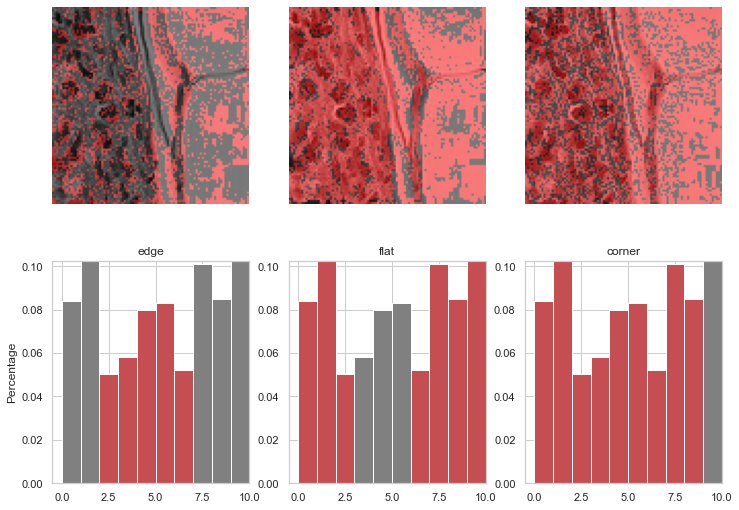

In [477]:
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = gray_random_image
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(12, 9))
plt.gray()

titles = ('edge', 'flat', 'corner')

w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')

for ax in ax_img:
    ax.axis('off')

We can see the different highlights in red for flat, edge and corner regions of the selected random image.

### Gabor filter

In [436]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi

In [453]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

def prepare_reference(image):
    image = row.image
    gray_image = 

In [458]:
# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))


random_image_negative = cv.cvtColor(cleaned_data[full_data_pd.is_cancer == False].sample(1, random_state=42)['image'].iloc[0], cv.COLOR_BGR2GRAY)
random_image_positive = cv.cvtColor(cleaned_data[full_data_pd.is_cancer == True].sample(1, random_state=55)['image'].iloc[0], cv.COLOR_BGR2GRAY)

negative = img_as_float(random_image1)[shrink]
positive = img_as_float(random_image2)[shrink]

image_names = cleaned_data['is_cancer'].values
images = (negative, positive)

# prepare reference features
ref_feats = np.zeros((len(cleaned_data), len(kernels), 2), dtype=np.double)

for i in range(0, len(cleaned_data['image'])-1):
    grey_image = cv.cvtColor(cleaned_data['image'].iloc[i], cv.COLOR_BGR2GRAY)
    grey_image_float = img_as_float(grey_image)[shrink]
    ref_feats[i, :, :] = compute_feats(grey_image_float, kernels)


/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/simonameriam/.conda/envs/data_sciense_keras_project/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Rotated images matched against references using Gabor filter banks:
original: negative, rotated: 30deg, match result: 

IndexError: tuple index out of range

In [467]:
image_names = cleaned_data['is_cancer'].values

Rotated images matched against references using Gabor filter banks:
original: positive, rotated: 30deg, match result: False
original: positive, rotated: 70deg, match result: True
original: negative, rotated: 145deg, match result: False


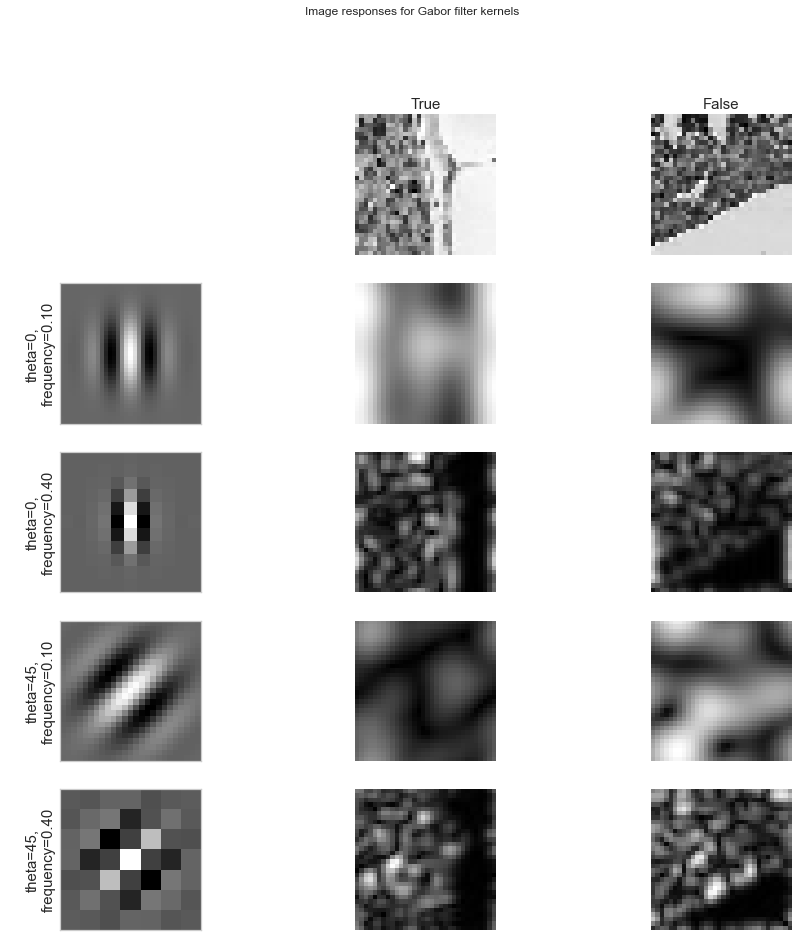

In [471]:

print('Rotated images matched against references using Gabor filter banks:')

print('original: positive, rotated: 30deg, match result: ', end='')
feats = compute_feats(ndi.rotate(positive, angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: positive, rotated: 70deg, match result: ', end='')
feats = compute_feats(ndi.rotate(positive, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: negative, rotated: 145deg, match result: ', end='')
feats = compute_feats(ndi.rotate(negative, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=15)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

## Clustering

In [490]:
from sklearn.cluster import KMeans

In [486]:
image_sample_stacked.shape

(20000, 27648)

In [492]:
reduced_data = PCA(n_components=3000).fit_transform(image_sample_stacked)

KeyboardInterrupt: 

In [494]:
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(image_sample_stacked)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = image_sample_stacked[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = image_sample_stacked[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(image_sample_stacked[:, 0], image_sample_stacked[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

ValueError: X has 2 features, but KMeans is expecting 27648 features as input.

## Dimentionality reduction - compression using principal component analysis (PCA)

Most of the pixels in the image are redunant, they do not contribute to the information we want to extract from the image. This pixel overhead will create a computational overhead while training our model so let's try to remove them. 

A general preprocessing method to relieve memory and compute limitations can create information loss which can be vital. Several methods have been explored to reduce image sizes like cropping and compression.

### cropping ###
- The images presented in this dataset have already undergone cropping. Since histalogical images are taken originally as WSIs, the patches are cropped from the original WSI. 
- As we've already mentioned, a positive label in the current dataset indicates that the center 32x32px region of a patch contains at least one pixel of tumor. We can argue for dimentionality reduction by utilizing the cropping of the image to only that center. We believe there are several problems with this approach, main one being the loss of spatial information between the outer cells and the central patch. 

### compression ###
Compression is widely used for two main purposes
- Minimizing the size of an image file without degradation in the image quality
- Reducing irrelevance and redundancy of data in the image

A compression technique called discrete wavelet transform (DWT) resolves the difficulty in high-resolution ship detection and performs better than conventional computer vision algorithms26. In addition, DWT is also useful for texture classification, because its finite duration provides both the frequency and spatial locality. In pathology, DWT analysis has been applied to classify tumors by using texture analysis

In this work, we propose a pathological image segmentation method in the compressed domain. To compress large pathological images, we utilized not only DWT but also principal component analysis (PCA) according to hematoxylin and eosin (H&E) staining characteristics to reduce 3-channel RGB data to one channel28.

### PCA
From our previous exploration using PCA we've found that to keep 90% of varience of the data we can compress down to First we'll split our image data into the three color channels

In [114]:
cleaned_data[['blue','green','red']] = cleaned_data.apply(lambda x: cv.split(x.image), axis=1, result_type='expand')

In [ ]:
cleaned_data.to_json("./split_clean.json")

We now have three columns for each of the color channels. Let's visualise a single image.

In [115]:
single_row = cleaned_data.iloc[0]

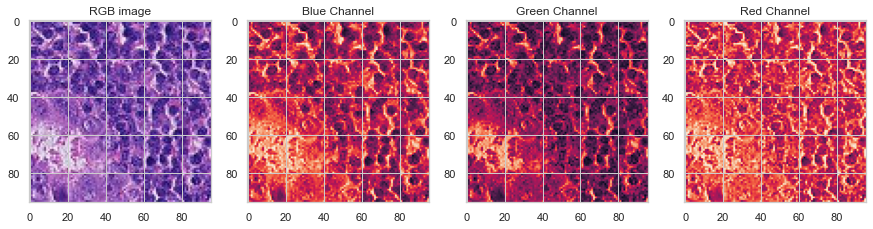

In [116]:
# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 

fig.add_subplot(141)
plt.title("RGB image")
plt.imshow(single_row['image'])

fig.add_subplot(142)
plt.title("Blue Channel")
plt.imshow(single_row['blue'])

fig.add_subplot(143)
plt.title("Green Channel")
plt.imshow(single_row['green'])

fig.add_subplot(144)
plt.title("Red Channel")
plt.imshow(single_row['red'])

plt.show()

We can see that we have the desired result. As seen before, the blue is the brightest channel with green being the darkest one. This aligns with the previous exploration of pixel brightness.

Lets try to compress an image using PCA and see how many principal components we should have.

In [9]:
#initialize PCA with first 20 principal components
pca = PCA(20)

#Applying to red channel and then applying inverse transform to transformed array.
red_transformed = pca.fit_transform(single_row['red'])
red_inverted = pca.inverse_transform(red_transformed)
 
#Applying to Green channel and then applying inverse transform to transformed array.
green_transformed = pca.fit_transform(single_row['green'])
green_inverted = pca.inverse_transform(green_transformed)
 
#Applying to Blue channel and then applying inverse transform to transformed array.
blue_transformed = pca.fit_transform(single_row['blue'])
blue_inverted = pca.inverse_transform(blue_transformed)

NameError: name 'single_row' is not defined

## Load image train set

Before the splitting out data, let's balance it. Althought the data is not very unbalanced, we decided to do this since the amount of images was taking us a lot of time to tain. We have to create dataframes containing the id's of each category and gather 89000 images as we said earlier randomly:

In [19]:
SAMPLE_SIZE=89000

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = cleaned_data[ cleaned_data['is_cancer'] == True ].sample(SAMPLE_SIZE, random_state = 42)

# filter out class 1
df_1 = cleaned_data[ cleaned_data['is_cancer'] == False ].sample(SAMPLE_SIZE, random_state = 42)

Once we created both dataframes we will concatenate them so as to have one file containing 178000 images, finally we will shuffle it because it was sorted:

In [20]:
from sklearn.utils import shuffle

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['is_cancer'].value_counts()

False    89000
True     89000
Name: is_cancer, dtype: int64

In [21]:
#df_data.drop('file_name',inplace=True, axis=1)
# df_data.drop('is_cancer',inplace=True, axis=1)

In [22]:
df_data.drop('is_low_contrast_0.1',inplace=True, axis=1)

In [23]:
df_data.head(10)

id  \
112085  d4a266b6bf4c18bcf4b0529fa84e3cc53149395e   
126705  3909329530e60dbaeee5fab14ee51c148eb8852a   
171852  ad51a5f3a66057a12b60b9c23689e3bf8e2c656e   
170874  3a934aebaee1136f03ab143a22f2935c9d45b58f   
79469   3c6a162a6b3b894602ae2c3a5686c69d6b4b63fc   
60651   6775b9dd001e965b31da7133d31f29867b1bd16d   
34537   28f056bc4dd436ec5061ae7f935b1f1b94f36aaf   
45930   11a6f45896d8ed5c77a9aff0080ff192d804865e   
41286   7f46c919ae182efb3376c6061bc6f12cefa8237b   
77897   5283fe1a96d3df3289b679352d68e25563dcf566   

                                                file_name  is_cancer  \
112085  ../../data/histopathologic-cancer-detection/tr...      False   
126705  ../../data/histopathologic-cancer-detection/tr...      False   
171852  ../../data/histopathologic-cancer-detection/tr...      False   
170874  ../../data/histopathologic-cancer-detection/tr...      False   
79469   ../../data/histopathologic-cancer-detection/tr...       True   
60651   ../../data/histopathologic-cancer-detection/tr...       True   
34537   ../../data/histopathologic-cancer-detection/tr...       True   
45930   ../../data/histopathologic-cancer-detection/tr...       True   
41286   ../../data/histopathologic-cancer-detection/tr...       True   
77897   ../../data/histopathologic-cancer-detection/tr...       True   

                                                    image  
112085  [[[251, 254, 252], [251, 254, 252], [252, 254,...  
126705  [[[114, 85, 135], [151, 125, 173], [244, 224, ...  
171852  [[[255, 180, 241], [129, 46, 98], [150, 57, 96...  
170874  [[[154, 86, 171], [162, 92, 175], [202, 133, 2...  
79469   [[[161, 61, 137], [194, 100, 184], [155, 70, 1...  
60651   [[[243, 165, 226], [202, 122, 183], [184, 98, ...  
34537   [[[105, 66, 128], [73, 35, 95], [117, 82, 139]...  
45930   [[[230, 159, 225], [166, 90, 148], [155, 74, 1...  
41286   [[[199, 132, 194], [215, 145, 208], [180, 110,...  
77897   [[[219, 140, 203], [218, 135, 210], [192, 105,...

Now that we have a balanced dataset we can split into training and validation sets at 10% as a typical ML workflow.

In [24]:
# train_test_split
from sklearn.model_selection import train_test_split

# stratify=y creates a balanced validation set.
y = df_data['is_cancer']

X_train, X_test, y_train, y_test = train_test_split(df_data, y, test_size=0.30, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(124600, 4)
(124600,)
(53400, 4)
(53400,)


At this moment we could create the model and the objects containing the training and validation images according to the id's in both sets, however this process will crash our machine RAM forcing us to restart it, this is why we have to create directories and sub-directories and save the images in their respective folder, this process will consume a significative lower RAM allowing us to succesfully train our model for various epochs.

In [110]:
# Create a new directory
base_dir = 'splitted_data'
os.mkdir(base_dir)

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create separate folders for each class

# create new folders inside train_dir
non_cancerous_tissue = os.path.join(train_dir, 'non_cancerous_tissue')
os.mkdir(non_cancerous_tissue)
cancerous_tissue = os.path.join(train_dir, 'cancerous_tissue')
os.mkdir(cancerous_tissue)

# create new folders inside val_dir
non_cancerous_tissue = os.path.join(val_dir, 'non_cancerous_tissue')
os.mkdir(non_cancerous_tissue)
cancerous_tissue = os.path.join(val_dir, 'cancerous_tissue')
os.mkdir(cancerous_tissue)


In [89]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [92]:
df_data.head

<bound method NDFrame.head of                                          label
id                                            
1c3f1795685060598187570a1b17440902387285     0
4884e9a48b68d6ab4a76440d2982c2f59bbdc86d     1
8aadbf6bb6666a650f9cc9637618286a5415a7f5     0
a6b8a17590d24338e5c1b308ebbe8bd46528eb46     0
7d6ec81d4cf93407f76378926c1737df8214cfce     0
...                                        ...
f2dd6373ddf242f6eb4792c41b0a541de8e3ac20     0
b6e7aee2aeebc2be737699d37c226784e0806080     0
719281706546465562db647f47ced381e4882833     1
d85b17275d81b1bb9dfddc5b49af0940e82bca39     1
481ca511c0d15df6ac0d4b0c916c8f9e089fbafe     0

[178000 rows x 1 columns]>

22/06/22 21:00:59 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 140275 ms exceeds timeout 120000 ms
22/06/22 21:00:59 WARN SparkContext: Killing executors is not supported by current scheduler.


In [111]:
import shutil

# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images
for image in train_list:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    # these must match the folder names
    if target == '0':
        label = 'non_cancerous_tissue'
    if target == '1':
        label = 'cancerous_tissue'

    # source path to image
    src = os.path.join('../../data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

    

# Transfer the val images
for image in val_list:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == '0':
        label = 'non_cancerous_tissue'
    if target == '1':
        label = 'cancerous_tissue'
    
    # source path to image
    src = os.path.join('../../data/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

## Dimentionality reduction - image compression

Most of the pixels in the image are redunant, they do not contribute to the information we want to extract from the image. This pixel overhead will create a computational overhead while training our model so let's try to remove them. We can do that using compression techniques. 

https://arxiv.org/pdf/1811.02840.pdf - Neural Image Compression for Gigapixel Histopathology Image Analysis

Dimentionality reduction (image compression) using PCA 
https://www.section.io/engineering-education/image-compression-using-pca/



Feature visualisation
https://learnopencv.com/t-sne-for-feature-visualization/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5956828/

## Dimentionality reduction using PCA

Our original dimentions are 96x96 = 9216.

In [107]:
from sklearn.decomposition import PCA

In [106]:
data_2 = df_data['image'].apply(compr)

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/thresh.cpp:1555: error: (-2:Unspecified error) in function 'double cv::threshold(cv::InputArray, cv::OutputArray, double, double, int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 16 (CV_8UC3)


In [25]:
from keras.preprocessing.image import ImageDataGenerator

#### The image data generator is going to rescale the images, deviding them by 255 so that pixel value ranges between 0 and 1

In [26]:
datagen = ImageDataGenerator(rescale=1./255,
                              
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip image

In [56]:
pca_dims = PCA()
pca_dims.fit(stacked_x_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

ValueError: Found array with dim 4. Estimator expected <= 2.

In [56]:
pca_dims = PCA()
pca_dims.fit(stacked_x_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

ValueError: Found array with dim 4. Estimator expected <= 2.

In [27]:
batch_size=32

In [28]:
train_path = 'splitted_data/train_dir'
valid_path = 'splitted_data/val_dir'

IMAGE_SIZE = 96

In [177]:
train_set = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True)

val_set = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True)




val2_set = datagen.flow_from_directory(valid_path,
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       batch_size=1,
                                       class_mode='binary',
                                       shuffle=False)

Found 160200 images belonging to 2 classes.
Found 17800 images belonging to 2 classes.
Found 17800 images belonging to 2 classes.


In [29]:
X_train.loc[X_train['is_cancer'] == True, 'is_cancer_bool'] = 'True'
X_train.loc[X_train['is_cancer'] == False, 'is_cancer_bool'] = 'False'
X_test.loc[X_test['is_cancer'] == True, 'is_cancer_bool'] = 'True'
X_test.loc[X_test['is_cancer'] == False, 'is_cancer_bool'] = 'False'

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124600 entries, 73632 to 137128
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              124600 non-null  object
 1   file_name       124600 non-null  object
 2   is_cancer       124600 non-null  bool  
 3   image           124600 non-null  object
 4   is_cancer_bool  124600 non-null  object
dtypes: bool(1), object(4)
memory usage: 4.9+ MB


In [99]:
train_set = datagen.flow_from_dataframe(X_train,
                                        featurewise_center=True,
                                        x_col='file_name',
                                        y_col='is_cancer_bool',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True)

val_set = datagen.flow_from_dataframe(X_test,
                                      featurewise_center=True,
                                        x_col='file_name',
                                        y_col='is_cancer_bool',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size,
                                        class_mode='binary',
                                        shuffle=True)

Found 124600 validated image filenames belonging to 2 classes.
Found 53400 validated image filenames belonging to 2 classes.


## Building our model

The model proposed here is similar to the one proposed by Dabeer, Sumaiya and Khan (2019). Dealing with similar data, they were proposing a method to solve the same binary classification problem but for breast cancer. The first 6 layers are the convolutional neural network and are used for feature extraction, the classification is done by the three last layers of the fully connected artificial neural network. They data was similary compressed to elimiate redundant pixels and reduce computational overhead. They trained the model on a lot less images, 7009, with a higher pixel resolution, 700x460. After image compression, they could train their model on their given hardware for 500 epochs which is something that is very hard for us at the moment since even training for 10 epochs takes a lot of time. We can try and subsample less images in the future.

In [100]:
cnn_model = models.Sequential()
cnn_model.add(layers.Input(shape=(96, 96, 3)))

cnn_model.add(layers.Conv2D(32, (5, 5), padding = 'same', activation = 'relu', name = 'L1'))
cnn_model.add(layers.MaxPooling2D((3, 3),name = 'L2'))

cnn_model.add(layers.Conv2D(64, (5, 5), activation = 'relu', name = 'L3'))
cnn_model.add(layers.MaxPooling2D((3, 3),name = 'L4'))

cnn_model.add(layers.Conv2D(128, (5, 5), activation = 'relu', name = 'L5'))
cnn_model.add(layers.MaxPooling2D((3, 3),name = 'L6'))

cnn_model.add(layers.Flatten(name = 'Flatten'))

# model.add(layers.Dense(64, activation='relu', name = 'ANNL1'))
# model.add(layers.Dense(64, activation='relu', name = 'ANNL2'))

# model.add(layers.Dense(2, activation='softmax', name = 'Decision'))

In [94]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Conv2D)                 (None, 96, 96, 32)        2432      
                                                                 
 L2 (MaxPooling2D)           (None, 32, 32, 32)        0         
                                                                 
 L3 (Conv2D)                 (None, 28, 28, 64)        51264     
                                                                 
 L4 (MaxPooling2D)           (None, 9, 9, 64)          0         
                                                                 
 L5 (Conv2D)                 (None, 5, 5, 128)         204928    
                                                                 
 L6 (MaxPooling2D)           (None, 1, 1, 128)         0         
                                                                 
 Flatten (Flatten)           (None, 128)              

In [96]:
earlystop_callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=0, min_lr=0.001)

In [101]:
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [102]:
cnn_history = cnn_model.fit(train_set, epochs=10, steps_per_epoch=3894, batch_size=3894,
                    validation_data=val_set, validation_batch_size=1669, 
                        callbacks=[earlystop_callback, reduce_lr_callback], verbose=1)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 873/3894 [=====>........................] - ETA: 8:24 - loss: 0.6999 - accuracy: 0.4997

KeyboardInterrupt: 

### Determining the size of the batch
So at this point we've actually got a pretty ugly exception if we'd set the batch size to be any number aside from 1. But then also not setting "steps_per_epoch" would put us in a bad position. 

Calculating the following metrics proves to be the same as len(train_set). So using this setting the "steps_per_epoch" is running a single image per set per the entire dataset. 

We then discovered that this exception was actually encountered because we didn't set the target_size=(96,96) in the previous section! We assumed that not setting target size would take the original image size, which is, (96,96). That assumption was clearly wrong.

In [86]:
train_steps_per_epoch = np.ceil(train_set.n / train_set.batch_size)
val_steps_per_epoch = np.ceil(val_set.n/ val_set.batch_size)

In [87]:
train_steps_per_epoch

3894.0

In [88]:
len(train_set)

3894

In [89]:
val_steps_per_epoch

1669.0

## Building our model

In [181]:
model = models.Sequential()
model.add(layers.Input(shape=(96, 96, 3)))

model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis = 3))



model.add(layers.Conv2D(32, (3, 3),activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis = 3))



model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis = 3))



model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [174]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 47, 47, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                      

## Compiling and fitting our model

In [182]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Notice no batch size and validation batch size are specified since our data is in the form of generator, and they already generate batches.

In [183]:
cnn_history = model.fit(train_set, epochs=10, steps_per_epoch=len(train_set),
                    validation_data=val_set,verbose=1)

Epoch 1/10
5007/5007 [==============================] - 875s 175ms/step - loss: 0.4087 - accuracy: 0.8265 - val_loss: 1.5007 - val_accuracy: 0.6546
Epoch 2/10
5007/5007 [==============================] - 5027s 1s/step - loss: 0.3077 - accuracy: 0.8732 - val_loss: 0.4016 - val_accuracy: 0.8267
Epoch 3/10
5007/5007 [==============================] - 1015s 203ms/step - loss: 0.2700 - accuracy: 0.8925 - val_loss: 0.6114 - val_accuracy: 0.7615
Epoch 4/10
5007/5007 [==============================] - 1071s 214ms/step - loss: 0.2509 - accuracy: 0.9008 - val_loss: 0.4086 - val_accuracy: 0.8359
Epoch 5/10
5007/5007 [==============================] - 985s 197ms/step - loss: 0.2375 - accuracy: 0.9069 - val_loss: 0.4539 - val_accuracy: 0.8017
Epoch 6/10
5007/5007 [==============================] - 966s 193ms/step - loss: 0.2258 - accuracy: 0.9126 - val_loss: 0.3290 - val_accuracy: 0.8751
Epoch 7/10
5007/5007 [==============================] - 981s 196ms/step - loss: 0.2196 - accuracy: 0.9151 - val_

Looking at the first epoch we've noticed the loss and accuracy don't really change afte raround 50-60K images

In [127]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [184]:
# Save the model
filepath_cnn = './CNN_model'
save_model(model, filepath_cnn)

INFO:tensorflow:Assets written to: ./CNN_model/assets


INFO:tensorflow:Assets written to: ./CNN_model/assets


## Using DenseNet201 as model base

In [172]:
from tensorflow.keras.applications import DenseNet201

In [149]:
# We read that best practice for output dropout layer is 0.5 (0.5<x<0.8 for input layers)
dropout_factor = 0.5

In [151]:
## TODO: Check trainability of DenseNet201 since we're using image net weights here and these should be quite different for cancer
model_base = DenseNet201(input_shape=(96, 96, 3), include_top=False)
dense_net = models.Sequential()
dense_net.add(model_base)

dense_net.add(layers.Flatten())

dense_net.add(layers.Dense(64, activation='relu'))
dense_net.add(layers.Dropout(0.2))
dense_net.add(layers.Dense(1, activation='sigmoid'))

In [152]:
dense_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 flatten_2 (Flatten)         (None, 17280)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1105984   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,428,033
Trainable params: 19,198,977
Non-trainable params: 229,056
_________________________________________________________________


In [153]:
dense_net.compile(optimizer=Adam(0.01),
              loss='binary_crossentropy',
              metrics=['accuracy','AUC'])

In [154]:
early_stopper = EarlyStopping(monitor='val_loss', patience=2, verbose=2, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [155]:
dense_history = model.fit(train_set, 
                    epochs=10, 
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_set, 
                    validation_steps=val_steps_per_epoch, 
                    callbacks=[early_stopper, reduce],
                    verbose=1)

Epoch 1/10
2504/2504 [==============================] - 905s 361ms/step - loss: 0.2444 - accuracy: 0.9076 - val_loss: 0.6229 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 2/10
2504/2504 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9112
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2504/2504 [==============================] - 966s 386ms/step - loss: 0.2367 - accuracy: 0.9112 - val_loss: 0.8886 - val_accuracy: 0.7918 - lr: 0.0010
Epoch 3/10
2504/2504 [==============================] - 920s 367ms/step - loss: 0.2151 - accuracy: 0.9208 - val_loss: 0.1739 - val_accuracy: 0.9314 - lr: 1.0000e-04
Epoch 4/10
2504/2504 [==============================] - 967s 386ms/step - loss: 0.2111 - accuracy: 0.9234 - val_loss: 0.1696 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 5/10
2504/2504 [==============================] - 1070s 427ms/step - loss: 0.2106 - accuracy: 0.9235 - val_loss: 0.1669 - val_accuracy: 0.9356 - lr: 1.0000e-04
Epoch 6/10
2504/25

In [156]:
# Save the model
filepath_dense = './Dense_model'
save_model(dense_net, filepath_dense)

INFO:tensorflow:Assets written to: ./Dense_model/assets


INFO:tensorflow:Assets written to: ./Dense_model/assets


In [49]:
def metrics_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1,1)

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Comparing the accuracy of two models

In [185]:
pd.DataFrame(cnn_history.history)

loss  accuracy  val_loss  val_accuracy
0  0.408654  0.826492  1.500675      0.654551
1  0.307730  0.873215  0.401563      0.826685
2  0.270044  0.892466  0.611382      0.761517
3  0.250899  0.900768  0.408614      0.835899
4  0.237514  0.906929  0.453924      0.801742
5  0.225813  0.912628  0.329013      0.875056
6  0.219594  0.915125  0.354196      0.873146
7  0.212308  0.918858  0.199580      0.922303
8  0.208533  0.920499  0.250245      0.902360
9  0.202283  0.923152  0.269790      0.899494

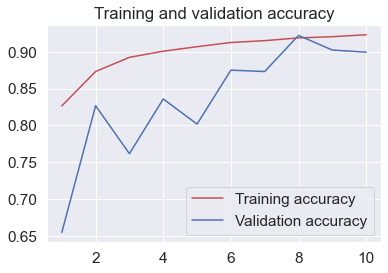

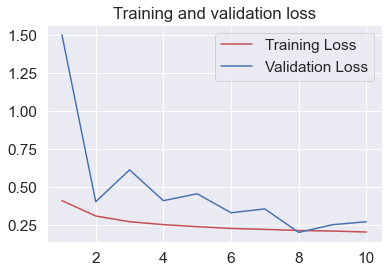

In [186]:
metrics_plot(cnn_history)

In [160]:
pd.DataFrame(dense_history.history)

loss  accuracy  val_loss  val_accuracy       lr
0  0.244418  0.907603  0.622871      0.813876  0.00100
1  0.236691  0.911223  0.888626      0.791798  0.00100
2  0.215138  0.920818  0.173853      0.931404  0.00010
3  0.211091  0.923408  0.169616      0.935000  0.00010
4  0.210582  0.923496  0.166915      0.935562  0.00010
5  0.206982  0.924800  0.196712      0.918708  0.00010
6  0.205494  0.924657  0.163769      0.935787  0.00001
7  0.206217  0.924650  0.162790      0.936573  0.00001
8  0.204642  0.925556  0.160880      0.936404  0.00001
9  0.204872  0.925175  0.160310      0.939494  0.00001

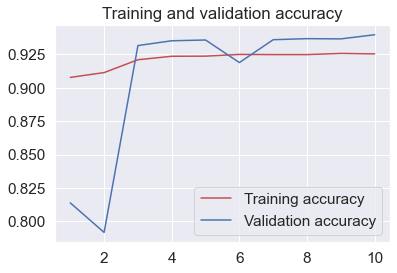

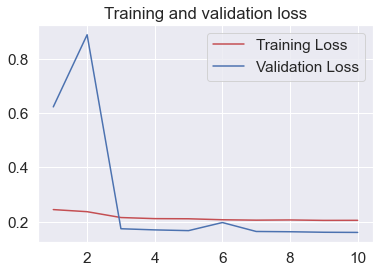

In [161]:
metrics_plot(dense_history)

Let's compare the accuracy of CNN model and DenseNet model.


At the moment our CNN model has an accuracy of ~85% on the training set and ~80% on the validation set. This means that we can expect our model to perform with ~80% accuracy on new data. On first two epochs our model accuracy metric increases on training set, while decreases on validation set. This means that our model is fitting the training set better, but is losing its ability to predict on new data, indicating that our model is starting to fit on noise and is beginning to overfit.But on the next epochs we see that accuracy of validation set is increasing. Still have to improve our model to get better accuracy and avoid the overfiting.

DenseNet model has an accuracy of ~89% on the training set and ~92% on validation set, it's much better than the CNN model. DenseNet model gives us higher accuracy on the validation set neither the training set. But the val_accuracy was getting higher only on two last epochs and got higher on ~15% than accuracy metric on first three epochs. On the third epoch we didn't get the accuracy of the validation set, because was no improvement since previous epoch.

In [187]:
from sklearn.metrics import confusion_matrix

In [188]:
#load the cnn and dense model
model_cnn = load_model(filepath_cnn, compile = True)
model_dense=load_model(filepath_dense,compile=True)

In [196]:
import matplotlib.pyplot as plt

In [189]:
predictions_cnn = model_cnn.predict_generator(val2_set, verbose=1)

   10/17800 [..............................] - ETA: 1:39 

/var/folders/rz/mg07kb5d5sq7nxt3pjc8x1v13yjw0y/T/ipykernel_1508/3537427310.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_cnn = model_cnn.predict_generator(val2_set, verbose=1)


17800/17800 [==============================] - 84s 5ms/step


In [190]:
y_val_pred_cnn=np.round(predictions_cnn)

In [191]:
y_val_pred_cnn

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [192]:
y_true = val2_set.classes

In [164]:
predictions_dense=model_dense.predict_generator(val2_set, verbose=1)

    1/17800 [..............................] - ETA: 30:29

/var/folders/rz/mg07kb5d5sq7nxt3pjc8x1v13yjw0y/T/ipykernel_1508/1453800772.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_dense=model_dense.predict_generator(val2_set, verbose=1)


17800/17800 [==============================] - 1101s 62ms/step


In [165]:
y_val_pred_dense=np.round(predictions_dense)

In [193]:
confusion_cnn_mtx = confusion_matrix(y_true, y_val_pred_cnn)
#confusion_dense_mtx = confusion_matrix(y_true,y_val_pred_dense)

In [166]:
confusion_dense_mtx = confusion_matrix(y_true,y_val_pred_dense)

In [194]:
confusion_cnn_mtx

array([[8061,  839],
       [ 957, 7943]])

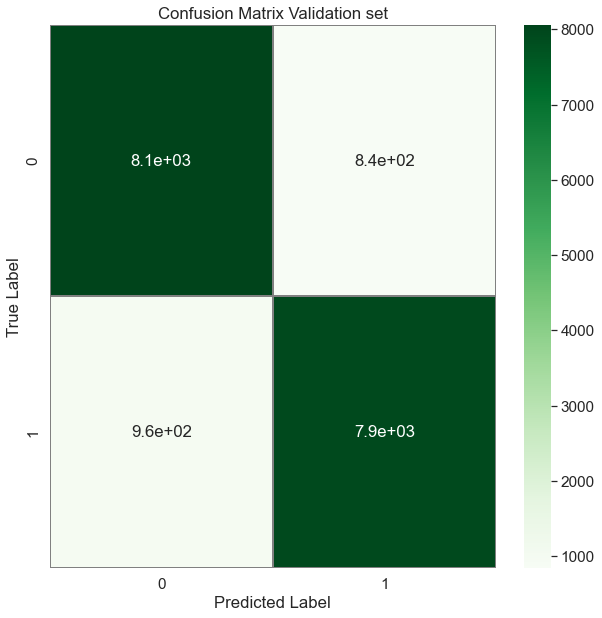

In [195]:
f,ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale=1.4)
sns.heatmap(confusion_cnn_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

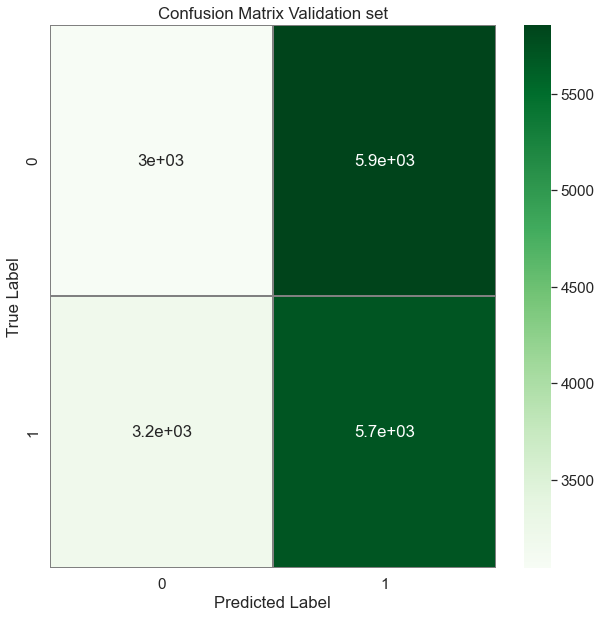

In [167]:
f,ax = plt.subplots(figsize=(10, 10))

sns.set(font_scale=1.4)
sns.heatmap(confusion_dense_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [197]:
ns_probs = [0 for _ in range(len(y_true))]

In [198]:

cnn_auc = roc_auc_score(y_true, y_val_pred_cnn)
#dense_auc=roc_auc_score(y_true, y_val_pred_dense)

In [168]:
dense_auc=roc_auc_score(y_true, y_val_pred_dense)

In [199]:
print('CNN: ROC AUC=%.3f' % (cnn_auc))
print('Dense: ROC AUC=%.3f' % (dense_auc))

CNN: ROC AUC=0.899
Dense: ROC AUC=0.491


In [200]:
ns_fpr_cnn, ns_tpr_cnn, _ = roc_curve(y_true, ns_probs)
lr_fpr_cnn, lr_tpr_cnn, _ = roc_curve(y_true,predictions_cnn)

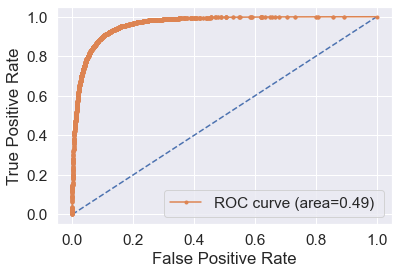

In [201]:
# plot the roc curve for the model
pyplot.plot(ns_fpr_cnn, ns_tpr_cnn, linestyle='--', label='')
pyplot.plot(lr_fpr_cnn, lr_tpr_cnn, marker='.', label='ROC curve (area=0.49) ')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [170]:
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_true, predictions_dense)


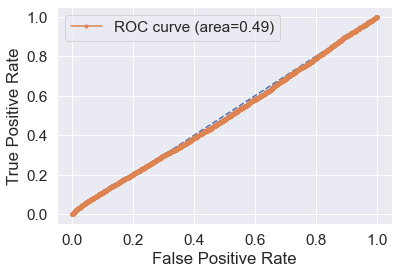

In [171]:
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ROC curve (area=0.49)')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

As we see from the graphs the value of the AUC is less then the random choice of 0.5, that's mean we should improve our model to get better accuracy on the new data. We run only 5 epochs ,so we are going to increase amount of epoch and see if it leads us to the highest accuracy on the new data.

### Plans for the next month 

1) Improve our CNN model
2) Integrate the shap tool 
3) Fix bugs that related to image pixel values distribution
4) We were trying to use k-means clustering for image classification as well but faced the problem on splitting our data to train and test sets while using the sklearn function train_test_split. The problem is the shape of the data is to big (200250,96,96,3), our machines haven't not enough cores to process this amount of data. We were thinking to use cuda, maybe you can advise us better ways to do so or just decrease this amount for clustering part? Thanks in advance.

## References
1. Alhindi, Taha J.; Kalra, Shivam; Ng, Ka Hin; Afrin, Anika; Tizhoosh, Hamid R. (2018). [IEEE 2018 International Joint Conference on Neural Networks (IJCNN) - Rio de Janeiro (2018.7.8-2018.7.13)] 2018 International Joint Conference on Neural Networks (IJCNN) - Comparing LBP, HOG and Deep Features for Classification of Histopathology Images. , (), 1–7. doi:10.1109/IJCNN.2018.8489329  
1. American Joint Committee on Cancer. AJCC Cancer Staging Manual, 8th ed. New York: Springer 2017: 715-725.
1. Cai J, Liu M, Zhang Q, Shao Z, Zhou J, Guo Y, Liu J, Wang X, Zhang B, Li X. Renal Cancer Detection: Fusing Deep and Texture Features from Histopathology Images. Biomed Res Int. 2022 Mar 28;2022:9821773. doi: 10.1155/2022/9821773. PMID: 35386304; PMCID: PMC8979690.
1. Dabeer, Sumaiya & Khan, Maha Mohammed & Islam, Saiful. (2019). Cancer diagnosis in histopathological image: CNN based approach. Informatics in Medicine Unlocked. 16. 100231. 10.1016/j.imu.2019.100231. 
1. Fox H. (2000). Is H&E morphology coming to an end?. Journal of clinical pathology, 53(1), 38–40. https://doi.org/10.1136/jcp.53.1.38
1. J.D. Bancroft, M. Gamble, Theory and practice of histological techniques, Elsevier health sciences, 2008
1. Krithiga, R., Geetha, P. Breast Cancer Detection, Segmentation and Classification on Histopathology Images Analysis: A Systematic Review. Arch Computat Methods Eng 28, 2607–2619 (2021). https://doi.org/10.1007/s11831-020-09470-w
1. Salvi, Massimo; Acharya, U.Rajendra; Molinari, Filippo; Meiburger, Kristen.M. (2020). The impact of pre- and post-image processing techniques on deep learning frameworks: a comprehensive review for digital pathology image analysis. Computers in Biology and Medicine, (), 104129–. doi:10.1016/j.compbiomed.2020.104129  
1. Wang, Xiaoyu & Han, Tony & Yan, Shuicheng. (2009). An HOG-LBP human detector with partial occlusion handling. ICCV. 32 - 39. 10.1109/ICCV.2009.5459207. 
